# **Bimodal Characteristic Returns and Predictability Enhancement via Machine Learning**
## **Chulwoo Han 2021**

## **样本选择与处理**

### **样本来源**：
- 数据库：CRSP（美国股市历史数据库）；
- 股票范围：所有上市普通股（Share code 10/11）；
- 市场范围：NYSE、Amex、Nasdaq（Exchange code 1/2/3）；
- 时间范围：1955年1月 – 2017年1月；
- 风险自由利率：使用国债收益率（T-bill）数据。

### **样本筛选标准**：
- 每个月需有 t-13 月价格数据，以及 t-2 月的收益；
- t-12 到 t-3 月间若缺失则填 -99；
- 必须有 t-1 月的市值数据；
- 若股票在持有期内退市，则使用退市回报（若缺失则默认 -30%）。

### **数据划分**：
- 训练集：1955.01 – 1974.12；
- 验证集：每年滚动训练时，后10年作为验证（例如 1975.01 的验证集为 1965.01 – 1974.12）；
- 测试期：1975.01 – 2017.01；
- 每年更新一次模型参数；
- 为控制机器学习随机性，每项实验重复 50 次，结果取平均。

In [1]:
import pandas as pd
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import numpy as np 
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mtick
from pandas.tseries.offsets import MonthEnd
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Pytorch库，用于DNN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from dateutil.relativedelta import relativedelta

# 支持进度条的多进程 map
from functools import partial
from tqdm.contrib.concurrent import process_map  

import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import log_loss
from tqdm import tqdm

from joblib import Parallel, delayed
import multiprocessing
from tqdm_joblib import tqdm_joblib
from multiprocessing import cpu_count
import time

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文黑体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

## **数据清洗**

In [2]:
# 导入CRSP数据
crsp = pd.read_csv('E:/zhaoweihao/DM 2016/1925-2018data.csv', dtype={'PERMNO': str})
cols_keep = ['PERMNO','date', 'SHRCD', 'EXCHCD', 'DLRET', 'PRC', 'RET', 'SHROUT']
crsp = crsp[cols_keep]

In [3]:
# 筛选时间范围：1953-12 到 2018-03
crsp["date"] = pd.to_datetime(crsp["date"], errors='coerce')
start_date = '1953-12-01'
end_date = '2018-03-31'
mask_date = (crsp['date'] >= start_date) & (crsp['date'] <= end_date)

# 筛选普通股（SHRCD=10或11）+ NYSE 或 AMEX（EXCHCD=1,2,3）
mask_shrcd = crsp['SHRCD'].isin([10, 11])
mask_exchcd = crsp['EXCHCD'].isin([1, 2, 3])
# 应用筛选条件
crsp = crsp[mask_date & mask_shrcd & mask_exchcd].copy()

In [4]:
total_permno = crsp['PERMNO'].nunique()
print(f"Total number of unique PERMNO values: {total_permno}")

Total number of unique PERMNO values: 24378


In [5]:
crsp.replace(["A", "S", "C", "T", "P"], np.nan, inplace = True)
crsp[["SHRCD", "EXCHCD", "SHROUT"]] = crsp[["SHRCD", "EXCHCD", "SHROUT"]].fillna(-99)
crsp[["PERMNO", "SHRCD", "EXCHCD", "SHROUT"]] = crsp[["PERMNO", "SHRCD", "EXCHCD", "SHROUT"]].astype(int)
crsp.replace([-99], np.nan, inplace = True)

In [6]:
crsp['DLRET'] = pd.to_numeric(crsp['DLRET'], errors='coerce')
crsp["RET"] = crsp["RET"].astype(float)
crsp["DLRET"] = crsp["DLRET"].astype(float)
crsp = crsp.sort_values(by=['date', 'PERMNO']).reset_index(drop=True)
df1 = crsp.copy()
df1.head()

,PERMNO,date,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT
0,10006,1953-12-31,10,1,NaN,31.75,-0.040590,725.0
1,10014,1953-12-31,10,1,NaN,2.00,-0.058824,1487.0
2,10022,1953-12-31,10,1,NaN,6.50,-0.036364,1514.0
3,10030,1953-12-31,10,1,NaN,35.00,-0.033784,1095.0
4,10057,1953-12-31,11,1,NaN,30.50,-0.031250,500.0


- 如果 DLRET 有值，就使用它；
- 如果股票退市但 DLRET 缺失，则用 –30%；
- 如果股票没退市，DLRET 本来就应该是空，我们可以安全地当作“无退市”，即 DLRET = 0。  
“If a stock delists during the holding period, I use the delisting return in CRSP; if unavailable, I use –30%...”

**由于没有DLSTCD字段**  
- 假设：  
    - DLRET 为缺失 → 当作没退市（DLRET = 0）  
    - DLRET 有值 → 使用该值

In [7]:
df1['DLRET_adj'] = df1['DLRET'].fillna(0.0)
# 合并退市回报
df1['RET_ADJ'] = (1 + df1['RET']) * (1 + df1['DLRET_adj']) - 1

In [8]:
# 计算市值，用于构建“规模哑变量
df1["MKTCAP"] = np.abs(df1["PRC"]) * df1["SHROUT"]
df2 = df1.sort_values(['date','PERMNO']).set_index(['PERMNO', 'date'])
df2

,,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT,DLRET_adj,RET_ADJ,MKTCAP
PERMNO,date,,,,,,,,,
10006,1953-12-31,10,1,NaN,31.75,-0.040590,725.0,0.0,-0.040590,23018.75
10014,1953-12-31,10,1,NaN,2.00,-0.058824,1487.0,0.0,-0.058824,2974.00
10022,1953-12-31,10,1,NaN,6.50,-0.036364,1514.0,0.0,-0.036364,9841.00
10030,1953-12-31,10,1,NaN,35.00,-0.033784,1095.0,0.0,-0.033784,38325.00
10057,1953-12-31,11,1,NaN,30.50,-0.031250,500.0,0.0,-0.031250,15250.00
...,...,...,...,...,...,...,...,...,...,...
93423,2018-03-29,11,1,NaN,62.26,-0.028554,84632.0,0.0,-0.028554,5269188.32
93426,2018-03-29,11,1,NaN,31.15,0.040067,12402.0,0.0,0.040067,386322.30
93429,2018-03-29,11,3,NaN,114.10,0.021070,112553.0,0.0,0.021070,12842297.30


#### **生成滞后收益、价格、市值（用于筛选条件）**

In [9]:
# t-1 到 t-13 的滞后收益
for lag in range(1, 14):
    df2[f'ret_lag{lag}'] = df2.groupby(level=0)['RET_ADJ'].shift(lag)
# t-13 月的价格（用于 MOM 构造）
df2['prc_lag13'] = df2.groupby(level=0)['PRC'].shift(13)
# t-1 月的市值
df2['me_lag1'] = df2.groupby(level=0)['MKTCAP'].shift(1)
# t-2 月的收益（必需）
df2['ret_lag2'] = df2.groupby(level=0)['RET_ADJ'].shift(2)
df2

,,SHRCD,EXCHCD,DLRET,PRC,RET,SHROUT,DLRET_adj,RET_ADJ,MKTCAP,ret_lag1,...,ret_lag6,ret_lag7,ret_lag8,ret_lag9,ret_lag10,ret_lag11,ret_lag12,ret_lag13,prc_lag13,me_lag1
PERMNO,date,,,,,,,,,,,,,,,,,,,,,
10006,1953-12-31,10,1,NaN,31.75,-0.040590,725.0,0.0,-0.040590,23018.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10014,1953-12-31,10,1,NaN,2.00,-0.058824,1487.0,0.0,-0.058824,2974.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10022,1953-12-31,10,1,NaN,6.50,-0.036364,1514.0,0.0,-0.036364,9841.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10030,1953-12-31,10,1,NaN,35.00,-0.033784,1095.0,0.0,-0.033784,38325.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10057,1953-12-31,11,1,NaN,30.50,-0.031250,500.0,0.0,-0.031250,15250.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93423,2018-03-29,11,1,NaN,62.26,-0.028554,84632.0,0.0,-0.028554,5269188.32,-0.039816,...,0.116731,-0.029189,-0.045965,-0.012753,-0.025395,0.052446,-0.018479,0.028030,60.61000,5418937.68
93426,2018-03-29,11,1,NaN,31.15,0.040067,12402.0,0.0,0.040067,386322.30,0.093066,...,0.116705,0.248571,0.011561,0.000000,0.005814,0.088608,-0.018634,-0.033033,16.10000,367366.70
93429,2018-03-29,11,3,NaN,114.10,0.021070,112553.0,0.0,0.021070,12842297.30,-0.166530,...,0.066805,0.070136,0.034245,0.058238,0.051086,0.016529,0.041896,-0.019719,78.05000,12624087.05


In [10]:
missing_values = df2.isnull().sum()
missing_values

SHRCD              0
EXCHCD             0
DLRET        3225555
PRC            38046
RET            62769
SHROUT          3593
DLRET_adj          0
RET_ADJ        62769
MKTCAP         38046
ret_lag1       66711
ret_lag2       90087
ret_lag3      114113
ret_lag4      138153
ret_lag5      162131
ret_lag6      186029
ret_lag7      209854
ret_lag8      233582
ret_lag9      257219
ret_lag10     280729
ret_lag11     304145
ret_lag12     327392
ret_lag13     350451
prc_lag13     327118
me_lag1        42013
dtype: int64

#### **构建 t−3 到 t−12 的滞后收益列表（共 10 期）**
筛选是否满足样本条件（生成 is_valid 列）

In [11]:
# 定义滞后收益列列表
ret_window = [f'ret_lag{i}' for i in range(3, 13)]
# 判断是否缺失
has_prc13 = df2['prc_lag13'].notna()
has_ret2 = df2['ret_lag2'].notna()
has_me1 = df2['me_lag1'].notna()
# 统计 ret_lag3 ~ ret_lag12 非缺失数量
ret_valid_count = df2[ret_window].notna().sum(axis=1)

# 合并为向量判断
df2['is_valid'] = has_prc13 & has_ret2 & has_me1 & (ret_valid_count >= 0) 
df2[ret_window] = df2[ret_window].fillna(-99)
output_cols = ['RET_ADJ', 'ret_lag1', 'me_lag1', 'ret_lag2', 'prc_lag13'] + ret_window + ['is_valid']
df3 = df2.loc[df2['is_valid'], output_cols].sort_values(['date', 'PERMNO'])
df3

,,RET_ADJ,ret_lag1,me_lag1,ret_lag2,prc_lag13,ret_lag3,ret_lag4,ret_lag5,ret_lag6,ret_lag7,ret_lag8,ret_lag9,ret_lag10,ret_lag11,ret_lag12,is_valid
PERMNO,date,,,,,,,,,,,,,,,,
10006,1955-01-31,-0.025253,0.053191,42421.50,0.136905,31.75000,-0.026087,-0.002890,0.121019,-0.003040,0.068182,0.120000,0.000000,-0.034364,0.035587,0.106299,True
10014,1955-01-31,0.423077,0.130435,4832.75,-0.080000,2.00000,0.063830,0.021739,-0.061224,0.166667,-0.160000,0.000000,0.000000,0.470588,-0.105263,0.187500,True
10022,1955-01-31,-0.056338,0.200000,13436.75,0.034483,6.50000,-0.064516,0.016129,-0.015873,0.125000,0.000000,-0.017241,0.074074,-0.017857,0.037037,0.038462,True
10030,1955-01-31,-0.003546,0.083333,38775.00,0.064516,35.00000,-0.060606,0.042802,-0.037453,0.076613,-0.168317,0.023649,-0.026316,0.003236,0.036913,0.064286,True
10057,1955-01-31,0.059113,0.040201,25375.00,0.140449,30.50000,-0.016575,0.064706,-0.071038,0.072464,-0.062500,0.088757,0.081250,0.134752,0.047619,0.118852,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93423,2018-03-29,-0.028554,-0.039816,5418937.68,0.014872,60.61000,0.017579,0.053034,0.030358,0.116731,-0.029189,-0.045965,-0.012753,-0.025395,0.052446,-0.018479,True
93426,2018-03-29,0.040067,0.093066,367366.70,0.089463,16.10000,-0.092058,0.128310,0.006148,0.116705,0.248571,0.011561,0.000000,0.005814,0.088608,-0.018634,True
93429,2018-03-29,0.021070,-0.166530,12624087.05,0.078658,78.05000,0.009398,0.094109,0.050451,0.066805,0.070136,0.034245,0.058238,0.051086,0.016529,0.041896,True


In [12]:
check = df3.reset_index()

In [13]:
total_permno = check['PERMNO'].nunique()
print(f"Total number of unique PERMNO values: {total_permno}")

Total number of unique PERMNO values: 23113


## **动量特征 MOM1 ~ MOM12**
### **变量设置与测量**
#### **输入变量（特征）**
两组主要特征：

**A. 动量特征（MOM）**：
MOM1M、MOM3M、MOM6M、MOM9M、MOM12M：不同周期的累计收益率；

**标准化处理**：每月对横截面标准化（去市场趋势影响）；

**宏观状态控制**：加入每期的动量平均值作为特征（MMOM）。

**B. 月度收益特征（RET）**：
最近12个月的原始月度收益；

同样进行横截面标准化，并加入横截面均值（MRET）控制市场状态。

**C. 市值哑变量（Size Dummies）**：
每月将股票按市值划分为 10 组，作为控制变量，用于改进加权组合表现。

In [14]:
# 构造 MOM1（即上月收益）
df_mom = df3.copy()
df_mom['MOM1'] = df_mom['ret_lag1']

In [15]:
# 定义通用复利函数
def compound_return_matrix(ret_matrix):
    valid_mask = (ret_matrix != -99) & (~np.isnan(ret_matrix))
    # 将无效值设置为 0（不影响乘积），因为 (1 + 0) = 1
    safe_returns = np.where(valid_mask, 1 + ret_matrix, 1.0)
    # 在行方向求乘积，再减 1
    compounded = np.prod(safe_returns, axis=1) - 1
    # 若某行全为无效值，则设为 NaN
    all_invalid = (~valid_mask).all(axis=1)
    compounded[all_invalid] = np.nan
    return compounded

In [16]:
# 构造 MOM3、MOM6、MOM9、MOM12
# 创建一个空列以便向量化处理
for m in [3, 6, 9, 12]:
    ret_cols = [f'ret_lag{i}' for i in range(m, 2, -1)]
    ret_matrix = df_mom[ret_cols].to_numpy()
    df_mom[f'MOM{m}'] = compound_return_matrix(ret_matrix)

#### **标准化动量特征（横截面去均值/方差）**
$$nMOM_m = (MOM_m−μ_t)/(σ_t)$$


In [17]:
for m in [1, 3, 6, 9, 12]:
    raw_col = f'MOM{m}'
    mean_col = f'MMOM{m}'
    norm_col = f'nMOM{m}'
    
    df_mom[mean_col] = df_mom.groupby('date', group_keys = False)[raw_col].transform('mean')
    df_mom[f'SD_{m}'] = df_mom.groupby('date', group_keys = False)[raw_col].transform('std')
    df_mom[norm_col] = (df_mom[raw_col] - df_mom[mean_col]) / df_mom[f'SD_{m}']

In [18]:
# 某月标准化动量分布
df_mom

,,RET_ADJ,ret_lag1,me_lag1,ret_lag2,prc_lag13,ret_lag3,ret_lag4,ret_lag5,ret_lag6,ret_lag7,...,nMOM3,MMOM6,SD_6,nMOM6,MMOM9,SD_9,nMOM9,MMOM12,SD_12,nMOM12
PERMNO,date,,,,,,,,,,,,,,,,,,,,,
10006,1955-01-31,-0.025253,0.053191,42421.50,0.136905,31.75000,-0.026087,-0.002890,0.121019,-0.003040,0.068182,...,-0.308288,0.10031,0.140756,-0.106567,0.180742,0.200907,0.585761,0.319637,0.271186,0.430740
10014,1955-01-31,0.423077,0.130435,4832.75,-0.080000,2.00000,0.063830,0.021739,-0.061224,0.166667,-0.160000,...,1.143060,0.10031,0.140756,0.640591,0.180742,0.200907,-0.899626,0.319637,0.271186,0.895565
10022,1955-01-31,-0.056338,0.200000,13436.75,0.034483,6.50000,-0.064516,0.016129,-0.015873,0.125000,0.000000,...,-0.928569,0.10031,0.140756,-0.340240,0.180742,0.200907,-0.347697,0.319637,0.271186,-0.533432
10030,1955-01-31,-0.003546,0.083333,38775.00,0.064516,35.00000,-0.060606,0.042802,-0.037453,0.076613,-0.168317,...,-0.865458,0.10031,0.140756,-0.605005,0.180742,0.200907,-1.688513,0.319637,0.271186,-1.430633
10057,1955-01-31,0.059113,0.040201,25375.00,0.140449,30.50000,-0.016575,0.064706,-0.071038,0.072464,-0.062500,...,-0.154755,0.10031,0.140756,-0.406012,0.180742,0.200907,-0.146660,0.319637,0.271186,0.780466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93423,2018-03-29,-0.028554,-0.039816,5418937.68,0.014872,60.61000,0.017579,0.053034,0.030358,0.116731,-0.029189,...,0.042920,0.12958,0.406934,0.254034,0.146196,0.496353,-0.037899,0.129746,0.522227,0.010082
93426,2018-03-29,0.040067,0.093066,367366.70,0.089463,16.10000,-0.092058,0.128310,0.006148,0.116705,0.248571,...,-0.685201,0.12958,0.406934,0.052712,0.146196,0.496353,0.619644,0.129746,0.522227,0.827930
93429,2018-03-29,0.021070,-0.166530,12624087.05,0.078658,78.05000,0.009398,0.094109,0.050451,0.066805,0.070136,...,-0.011412,0.12958,0.406934,0.265473,0.146196,0.496353,0.611142,0.129746,0.522227,0.926636


| 字段              | 含义             |
| --------------- | -------------- |
| MOM1 \~ MOM12   | 原始动量收益         |
| nMOM1 \~ nMOM12 | 横截面标准化动量       |
| MMOM1 \~ MMOM12 | 每月横截面均值        |
| SD\_m           | 每月横截面标准差（辅助计算） |

In [19]:
print(df_mom.columns)

Index(['RET_ADJ', 'ret_lag1', 'me_lag1', 'ret_lag2', 'prc_lag13', 'ret_lag3',
       'ret_lag4', 'ret_lag5', 'ret_lag6', 'ret_lag7', 'ret_lag8', 'ret_lag9',
       'ret_lag10', 'ret_lag11', 'ret_lag12', 'is_valid', 'MOM1', 'MOM3',
       'MOM6', 'MOM9', 'MOM12', 'MMOM1', 'SD_1', 'nMOM1', 'MMOM3', 'SD_3',
       'nMOM3', 'MMOM6', 'SD_6', 'nMOM6', 'MMOM9', 'SD_9', 'nMOM9', 'MMOM12',
       'SD_12', 'nMOM12'],
      dtype='object')


## **构造月收益标签**

In [20]:
df_label = df_mom.copy()
# 为每只股票生成 t+1 的未来月收益
df_label['ret_lead1'] = df_label.groupby(level=0)['RET_ADJ'].shift(-1)
df_label.head()

,,RET_ADJ,ret_lag1,me_lag1,ret_lag2,prc_lag13,ret_lag3,ret_lag4,ret_lag5,ret_lag6,ret_lag7,...,MMOM6,SD_6,nMOM6,MMOM9,SD_9,nMOM9,MMOM12,SD_12,nMOM12,ret_lead1
PERMNO,date,,,,,,,,,,,,,,,,,,,,,
10006,1955-01-31,-0.025253,0.053191,42421.50,0.136905,31.75,-0.026087,-0.002890,0.121019,-0.003040,0.068182,...,0.10031,0.140756,-0.106567,0.180742,0.200907,0.585761,0.319637,0.271186,0.430740,0.145078
10014,1955-01-31,0.423077,0.130435,4832.75,-0.080000,2.00,0.063830,0.021739,-0.061224,0.166667,-0.160000,...,0.10031,0.140756,0.640591,0.180742,0.200907,-0.899626,0.319637,0.271186,0.895565,-0.054054
10022,1955-01-31,-0.056338,0.200000,13436.75,0.034483,6.50,-0.064516,0.016129,-0.015873,0.125000,0.000000,...,0.10031,0.140756,-0.340240,0.180742,0.200907,-0.347697,0.319637,0.271186,-0.533432,0.059701
10030,1955-01-31,-0.003546,0.083333,38775.00,0.064516,35.00,-0.060606,0.042802,-0.037453,0.076613,-0.168317,...,0.10031,0.140756,-0.605005,0.180742,0.200907,-1.688513,0.319637,0.271186,-1.430633,0.017794
10057,1955-01-31,0.059113,0.040201,25375.00,0.140449,30.50,-0.016575,0.064706,-0.071038,0.072464,-0.062500,...,0.10031,0.140756,-0.406012,0.180742,0.200907,-0.146660,0.319637,0.271186,0.780466,0.097674


#### **分组方向应为降序（高收益 = 类别1）**
- **原文使用的标签是**：
类别 1 = 高未来收益组，类别 10 = 低未来收益组，即：  
“... stocks are labeled 1 (H) to 10 (L) based on the one-month ahead return (in descending order)”

In [21]:
# 构造标签：横截面分组（十组）Decile Label
def make_decile_labels_desc(x):
    return pd.qcut(-x, q=10, labels=False, duplicates='drop') + 1  # 高收益变小数值

df_label['label'] = df_label.groupby('date')['ret_lead1'].transform(make_decile_labels_desc)

In [22]:
df_label.head()

,,RET_ADJ,ret_lag1,me_lag1,ret_lag2,prc_lag13,ret_lag3,ret_lag4,ret_lag5,ret_lag6,ret_lag7,...,SD_6,nMOM6,MMOM9,SD_9,nMOM9,MMOM12,SD_12,nMOM12,ret_lead1,label
PERMNO,date,,,,,,,,,,,,,,,,,,,,,
10006,1955-01-31,-0.025253,0.053191,42421.50,0.136905,31.75,-0.026087,-0.002890,0.121019,-0.003040,0.068182,...,0.140756,-0.106567,0.180742,0.200907,0.585761,0.319637,0.271186,0.430740,0.145078,1.0
10014,1955-01-31,0.423077,0.130435,4832.75,-0.080000,2.00,0.063830,0.021739,-0.061224,0.166667,-0.160000,...,0.140756,0.640591,0.180742,0.200907,-0.899626,0.319637,0.271186,0.895565,-0.054054,10.0
10022,1955-01-31,-0.056338,0.200000,13436.75,0.034483,6.50,-0.064516,0.016129,-0.015873,0.125000,0.000000,...,0.140756,-0.340240,0.180742,0.200907,-0.347697,0.319637,0.271186,-0.533432,0.059701,4.0
10030,1955-01-31,-0.003546,0.083333,38775.00,0.064516,35.00,-0.060606,0.042802,-0.037453,0.076613,-0.168317,...,0.140756,-0.605005,0.180742,0.200907,-1.688513,0.319637,0.271186,-1.430633,0.017794,7.0
10057,1955-01-31,0.059113,0.040201,25375.00,0.140449,30.50,-0.016575,0.064706,-0.071038,0.072464,-0.062500,...,0.140756,-0.406012,0.180742,0.200907,-0.146660,0.319637,0.271186,0.780466,0.097674,2.0


In [23]:
missing_values = df_label.isnull().sum()
missing_values

RET_ADJ      22310
ret_lag1      1041
me_lag1          0
ret_lag2         0
prc_lag13        0
ret_lag3         0
ret_lag4         0
ret_lag5         0
ret_lag6         0
ret_lag7         0
ret_lag8         0
ret_lag9         0
ret_lag10        0
ret_lag11        0
ret_lag12        0
is_valid         0
MOM1          1041
MOM3          2916
MOM6           149
MOM9            49
MOM12            1
MMOM1            0
SD_1             0
nMOM1         1041
MMOM3            0
SD_3             0
nMOM3         2916
MMOM6            0
SD_6             0
nMOM6          149
MMOM9            0
SD_9             0
nMOM9           49
MMOM12           0
SD_12            0
nMOM12           1
ret_lead1    45254
label        45254
dtype: int64

In [24]:
# 去除未来收益为缺失值的样本（无标签）
df_label = df_label[~df_label['label'].isna()]
df_label['label'] = df_label['label'].astype(int)

#### **构造“binary”或“三分类”标签**
- 可选设定：分为高/中/低三类：
    - Bottom 3 deciles → label = 0（低）
    - Middle 4 deciles → label = 1（中）
    - Top 3 deciles → label = 2（高）

##### 若需三分类版本（不一定用于回归）
def make_triple_class_label(x):
    return pd.qcut(x, q=[0, 0.3, 0.7, 1.0], labels=[0, 1, 2], duplicates='drop')

df_label['label_3class'] = df_label.groupby('date')['ret_lead1'].transform(make_triple_class_label)

| 字段             | 含义             |
| -------------- | -------------- |
| `ret_lead1`    | 下一期月度收益（未来收益）  |
| `label`        | 十分位收益标签（1\~10） |
| `label_3class` | 三分类标签（低中高）- 可选 |


In [25]:
check = df_label.reset_index()

In [26]:
# 查看某个月份的收益标签分布
check[check['date'] == '2005-06-30'][['ret_lead1', 'label']].describe()

,ret_lead1,label
count,4456.000000,4456.000000
mean,0.065706,5.499551
std,0.138947,2.873072
min,-0.651852,1.000000
25%,0.000000,3.000000
50%,0.047386,5.500000
75%,0.112223,8.000000
max,1.899225,10.000000


In [28]:
# 查看某只股票的标签轨迹
check[check['PERMNO'] == 10107][['date', 'ret_lead1', 'label']].sort_values('date')

,date,ret_lead1,label
1078386,1987-04-30,0.108173,2
1083438,1987-05-29,-0.114967,10
1088519,1987-06-30,-0.078431,9
1093647,1987-07-31,0.263298,1
1098845,1987-08-31,0.115789,1
...,...,...,...
2846945,2017-10-31,0.016951,6
2850291,2017-11-30,0.016277,4
2853637,2017-12-29,0.110708,2
2856982,2018-01-31,-0.008631,4


In [29]:
start = '1955-01-01'
end = '2017-01-31'
# 筛选数据框
check = check[(check['date'] >= start) & (check['date'] <= end)]
total_permno = check['PERMNO'].nunique()
print(f"Total number of unique PERMNO values: {total_permno}")

Total number of unique PERMNO values: 22659


- **原文明确说明，总共 22,919 家公司**；
- 月度样本量范围：994（最小，1955.11）到 6,777（最大，1997.11）

**这里有点不符合，那么需要重新审视数据处理步骤**

## **补充市值哑变量 + RET-NOM 和 RET-ORD**

In [31]:
# 拷贝 DataFrame 以继续处理
df_size = check.copy()
df_size = df_size[df_size['me_lag1'].notna()]

# 每月对 me_lag1 排序，分成 10 组（注意升序）
df_size['size_decile'] = (df_size.groupby('date')['me_lag1'].transform(lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop') + 1))
df_size.head(3)

,PERMNO,date,RET_ADJ,ret_lag1,me_lag1,ret_lag2,prc_lag13,ret_lag3,ret_lag4,ret_lag5,...,nMOM6,MMOM9,SD_9,nMOM9,MMOM12,SD_12,nMOM12,ret_lead1,label,size_decile
0,10006,1955-01-31,-0.025253,0.053191,42421.50,0.136905,31.75,-0.026087,-0.002890,0.121019,...,-0.106567,0.180742,0.200907,0.585761,0.319637,0.271186,0.430740,0.145078,1,6
1,10014,1955-01-31,0.423077,0.130435,4832.75,-0.080000,2.00,0.063830,0.021739,-0.061224,...,0.640591,0.180742,0.200907,-0.899626,0.319637,0.271186,0.895565,-0.054054,10,1
2,10022,1955-01-31,-0.056338,0.200000,13436.75,0.034483,6.50,-0.064516,0.016129,-0.015873,...,-0.340240,0.180742,0.200907,-0.347697,0.319637,0.271186,-0.533432,0.059701,4,3


In [32]:
# 构建 10 个哑变量（Dummy Variables）
# 将 decile 编码展开为 10 个 0/1 哑变量列
size_dummies = pd.get_dummies(df_size['size_decile'], prefix='size')
size_dummies = size_dummies.astype(int)
# 将它们拼接回原数据
df_size = pd.concat([df_size, size_dummies], axis=1)
df_size.head(3)

,PERMNO,date,RET_ADJ,ret_lag1,me_lag1,ret_lag2,prc_lag13,ret_lag3,ret_lag4,ret_lag5,...,size_1,size_2,size_3,size_4,size_5,size_6,size_7,size_8,size_9,size_10
0,10006,1955-01-31,-0.025253,0.053191,42421.50,0.136905,31.75,-0.026087,-0.002890,0.121019,...,0,0,0,0,0,1,0,0,0,0
1,10014,1955-01-31,0.423077,0.130435,4832.75,-0.080000,2.00,0.063830,0.021739,-0.061224,...,1,0,0,0,0,0,0,0,0,0
2,10022,1955-01-31,-0.056338,0.200000,13436.75,0.034483,6.50,-0.064516,0.016129,-0.015873,...,0,0,1,0,0,0,0,0,0,0


In [33]:
# 针对过去12个月月收益进行标准化
for m in range(1, 13):
    col_ret = f'ret_lag{m}'     # 原始收益列，如 ret_lag1
    col_mean = f'MRET{m}'       # 横截面均值
    col_std = f'SD_RET{m}'      # 横截面标准差（可选）
    col_norm = f'nRET{m}'       # 标准化收益列
    # 横截面均值和标准差（按月份）
    df_size[col_mean] = df_size.groupby('date')[col_ret].transform('mean')
    df_size[col_std] = df_size.groupby('date')[col_ret].transform('std')
    # 横截面 Z-score 标准化
    df_size[col_norm] = (df_size[col_ret] - df_size[col_mean]) / df_size[col_std]
df_size

,PERMNO,date,RET_ADJ,ret_lag1,me_lag1,ret_lag2,prc_lag13,ret_lag3,ret_lag4,ret_lag5,...,nRET9,MRET10,SD_RET10,nRET10,MRET11,SD_RET11,nRET11,MRET12,SD_RET12,nRET12
0,10006,1955-01-31,-0.025253,0.053191,42421.50,0.136905,31.75000,-0.026087,-0.002890,0.121019,...,-0.244015,0.02869,0.065932,-0.956355,0.013440,0.059736,0.370753,0.071231,0.064421,0.544360
1,10014,1955-01-31,0.423077,0.130435,4832.75,-0.080000,2.00000,0.063830,0.021739,-0.061224,...,-0.244015,0.02869,0.065932,6.702338,0.013440,0.059736,-1.987124,0.071231,0.064421,1.804830
2,10022,1955-01-31,-0.056338,0.200000,13436.75,0.034483,6.50000,-0.064516,0.016129,-0.015873,...,0.823136,0.02869,0.065932,-0.705991,0.013440,0.059736,0.395027,0.071231,0.064421,-0.508663
3,10030,1955-01-31,-0.003546,0.083333,38775.00,0.064516,35.00000,-0.060606,0.042802,-0.037453,...,-0.623138,0.02869,0.065932,-0.386070,0.013440,0.059736,0.392951,0.071231,0.064421,-0.107801
4,10057,1955-01-31,0.059113,0.040201,25375.00,0.140449,30.50000,-0.016575,0.064706,-0.071038,...,0.926517,0.02869,0.065932,1.608656,0.013440,0.059736,0.572173,0.071231,0.064421,0.739218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819900,93426,2017-01-31,-0.119048,0.035616,229956.30,0.162420,11.32000,-0.020586,0.049771,0.161217,...,0.035065,0.08114,0.170481,0.670176,0.002672,0.148566,-0.074927,-0.092075,0.146596,0.929387
2819901,93428,2017-01-31,0.018182,-0.006024,1252061.25,-0.001203,35.36000,-0.107411,0.018377,0.019630,...,-0.022115,0.08114,0.170481,0.074215,0.002672,0.148566,0.509325,-0.092075,0.146596,0.406228
2819902,93429,2017-01-31,0.077548,0.072424,6006148.65,0.093973,64.90000,-0.025289,-0.055903,0.002035,...,-0.035187,0.08114,0.170481,-0.188759,0.002672,0.148566,-0.434248,-0.092075,0.146596,0.808865
2819903,93434,2017-01-31,0.000000,-0.041667,82560.80,-0.049505,4.22000,-0.009804,0.062500,0.002088,...,0.052880,0.08114,0.170481,-0.489948,0.002672,0.148566,0.063308,-0.092075,0.146596,0.498768


In [34]:
df_size[df_size['date'] == '2015-08-31'][['nRET1', 'nRET2', 'nRET12']].describe()

,nRET1,nRET2,nRET12
count,3.509000e+03,3.511000e+03,3.511000e+03
mean,-1.012458e-17,4.047523e-18,-2.023762e-18
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.059234e+00,-4.962568e+00,-2.958163e+01
25%,-4.151727e-01,-4.559696e-01,1.940759e-02
50%,9.969564e-02,-2.327345e-02,3.187199e-02
75%,5.166463e-01,4.410056e-01,4.528788e-02
max,7.413458e+00,9.654429e+00,1.175521e+00


In [36]:
df_size.columns

Index(['PERMNO', 'date', 'RET_ADJ', 'ret_lag1', 'me_lag1', 'ret_lag2',
       'prc_lag13', 'ret_lag3', 'ret_lag4', 'ret_lag5', 'ret_lag6', 'ret_lag7',
       'ret_lag8', 'ret_lag9', 'ret_lag10', 'ret_lag11', 'ret_lag12',
       'is_valid', 'MOM1', 'MOM3', 'MOM6', 'MOM9', 'MOM12', 'MMOM1', 'SD_1',
       'nMOM1', 'MMOM3', 'SD_3', 'nMOM3', 'MMOM6', 'SD_6', 'nMOM6', 'MMOM9',
       'SD_9', 'nMOM9', 'MMOM12', 'SD_12', 'nMOM12', 'ret_lead1', 'label',
       'size_decile', 'size_1', 'size_2', 'size_3', 'size_4', 'size_5',
       'size_6', 'size_7', 'size_8', 'size_9', 'size_10', 'MRET1', 'SD_RET1',
       'nRET1', 'MRET2', 'SD_RET2', 'nRET2', 'MRET3', 'SD_RET3', 'nRET3',
       'MRET4', 'SD_RET4', 'nRET4', 'MRET5', 'SD_RET5', 'nRET5', 'MRET6',
       'SD_RET6', 'nRET6', 'MRET7', 'SD_RET7', 'nRET7', 'MRET8', 'SD_RET8',
       'nRET8', 'MRET9', 'SD_RET9', 'nRET9', 'MRET10', 'SD_RET10', 'nRET10',
       'MRET11', 'SD_RET11', 'nRET11', 'MRET12', 'SD_RET12', 'nRET12'],
      dtype='object')

In [37]:
# 在主逻辑前，只需对一次 df_final 做：
df_size['month_period'] = df_size['date'].dt.to_period('M')

In [38]:
columns_to_keep = ['PERMNO', 'month_period', 'RET_ADJ', 'MOM1', 'MOM3', 'MOM6', 'MOM9', 'MOM12', 'MMOM1', 'nMOM1', 'MMOM3', 'nMOM3', 
                   'MMOM6', 'nMOM6', 'MMOM9', 'nMOM9', 'MMOM12', 'nMOM12', 'ret_lead1', 'label', 'size_decile', 'size_1', 'size_2', 
                   'size_3', 'size_4', 'size_5', 'size_6', 'size_7', 'size_8', 'size_9', 'size_10', 'MRET1', 'nRET1', 'MRET2', 'nRET2', 
                   'MRET3', 'nRET3', 'MRET4','nRET4', 'MRET5', 'nRET5', 'MRET6', 'nRET6','MRET7', 'nRET7', 'MRET8', 'nRET8', 'MRET9', 
                   'nRET9', 'MRET10', 'nRET10', 'MRET11', 'nRET11', 'MRET12', 'nRET12']

df_final = df_size[columns_to_keep]
df_final.tail()

,PERMNO,month_period,RET_ADJ,MOM1,MOM3,MOM6,MOM9,MOM12,MMOM1,nMOM1,...,MRET8,nRET8,MRET9,nRET9,MRET10,nRET10,MRET11,nRET11,MRET12,nRET12
2819900,93426,2017-01,-0.119048,0.035616,-0.020586,0.169897,0.120629,0.386928,0.019934,0.114312,...,0.001869,-0.738525,0.008216,0.035065,0.08114,0.670176,0.002672,-0.074927,-0.092075,0.929387
2819901,93428,2017-01,0.018182,-0.006024,-0.107411,0.012675,0.029741,0.175057,0.019934,-0.189212,...,0.001869,0.832537,0.008216,-0.022115,0.08114,0.074215,0.002672,0.509325,-0.092075,0.406228
2819902,93429,2017-01,0.077548,0.072424,-0.025289,-0.047732,-0.025575,-0.015666,0.019934,0.382613,...,0.001869,0.189928,0.008216,-0.035187,0.08114,-0.188759,0.002672,-0.434248,-0.092075,0.808865
2819903,93434,2017-01,0.000000,-0.041667,-0.009804,0.158257,0.208134,0.196682,0.019934,-0.449021,...,0.001869,-0.079119,0.008216,0.052880,0.08114,-0.489948,0.002672,0.063308,-0.092075,0.498768
2819904,93436,2017-01,0.178951,0.128247,-0.030878,-0.068542,-0.139445,-0.176161,0.019934,0.789519,...,0.001869,-0.558263,0.008216,0.023309,0.08114,0.680517,0.002672,0.007716,-0.092075,-0.759177


In [39]:
del crsp, df1, missing_values, has_prc13, has_ret2, has_me1, ret_valid_count,df2, df3, df_mom, df_size, size_dummies, df_label, check

In [40]:
df_final

,PERMNO,month_period,RET_ADJ,MOM1,MOM3,MOM6,MOM9,MOM12,MMOM1,nMOM1,...,MRET8,nRET8,MRET9,nRET9,MRET10,nRET10,MRET11,nRET11,MRET12,nRET12
0,10006,1955-01,-0.025253,0.053191,-0.026087,0.085310,2.984261e-01,0.436448,0.088672,-0.365856,...,0.042449,1.167251,0.016938,-0.244015,0.02869,-0.956355,0.013440,0.370753,0.071231,0.544360
1,10014,1955-01,0.423077,0.130435,0.063830,0.190477,8.797940e-07,0.562501,0.088672,0.430636,...,0.042449,-0.638911,0.016938,-0.244015,0.02869,6.702338,0.013440,-1.987124,0.071231,1.804830
2,10022,1955-01,-0.056338,0.200000,-0.064516,0.052419,1.108876e-01,0.174978,0.088672,1.147946,...,0.042449,-0.898411,0.016938,0.823136,0.02869,-0.705991,0.013440,0.395027,0.071231,-0.508663
3,10030,1955-01,-0.003546,0.083333,-0.060606,0.015152,-1.584922e-01,-0.068330,0.088672,-0.055051,...,0.042449,-0.282961,0.016938,-0.623138,0.02869,-0.386070,0.013440,0.392951,0.071231,-0.107801
4,10057,1955-01,0.059113,0.040201,-0.016575,0.043162,1.512774e-01,0.531288,0.088672,-0.499801,...,0.042449,0.697002,0.016938,0.926517,0.02869,1.608656,0.013440,0.572173,0.071231,0.739218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819900,93426,2017-01,-0.119048,0.035616,-0.020586,0.169897,1.206295e-01,0.386928,0.019934,0.114312,...,0.001869,-0.738525,0.008216,0.035065,0.08114,0.670176,0.002672,-0.074927,-0.092075,0.929387
2819901,93428,2017-01,0.018182,-0.006024,-0.107411,0.012675,2.974075e-02,0.175057,0.019934,-0.189212,...,0.001869,0.832537,0.008216,-0.022115,0.08114,0.074215,0.002672,0.509325,-0.092075,0.406228
2819902,93429,2017-01,0.077548,0.072424,-0.025289,-0.047732,-2.557534e-02,-0.015666,0.019934,0.382613,...,0.001869,0.189928,0.008216,-0.035187,0.08114,-0.188759,0.002672,-0.434248,-0.092075,0.808865
2819903,93434,2017-01,0.000000,-0.041667,-0.009804,0.158257,2.081341e-01,0.196682,0.019934,-0.449021,...,0.001869,-0.079119,0.008216,0.052880,0.08114,-0.489948,0.002672,0.063308,-0.092075,0.498768


## **训练、验证、测试集划分**
“The first twenty years (1955.01 to 1974.12) of the sample are used to train the models, and the test period starts at 1975.01. The models are retrained every year stacking the sample while holding the last ten years of the data for validation...”

In [41]:
# 设置训练起点和终点
start_test = datetime(1975, 1, 31)
end_test = datetime(2017, 1, 31)

samples = []
current_test = start_test

while current_test <= end_test:
    # 所有关键日期都先退到当月第一天再加 MonthEnd(0)，确保是当月月末
    test_month = current_test.replace(day=1) + MonthEnd(0)
    val_start = (test_month - relativedelta(years=10)).replace(day=1) + MonthEnd(0)
    val_end   = (test_month - relativedelta(months=1)).replace(day=1) + MonthEnd(0)
    train_end = (val_start - relativedelta(months=1)).replace(day=1) + MonthEnd(0)
    train_start = datetime(1955, 1, 31)  # 固定

    samples.append({
        'test_month': test_month.strftime('%Y-%m-%d'),
        'train_start': train_start.strftime('%Y-%m-%d'),
        'train_end': train_end.strftime('%Y-%m-%d'),
        'val_start': val_start.strftime('%Y-%m-%d'),
        'val_end': val_end.strftime('%Y-%m-%d')
    })

    current_test += relativedelta(months=1)

In [42]:
sample_months = pd.Series([s['test_month'] for s in samples], name='sample_month')
sample_months = pd.to_datetime(sample_months).dt.to_period('M')
sample_months

0      1975-01
1      1975-02
2      1975-03
3      1975-04
4      1975-05
        ...   
500    2016-09
501    2016-10
502    2016-11
503    2016-12
504    2017-01
Name: sample_month, Length: 505, dtype: period[M]

## **Table 2**
1. 训练分类器（Nominal / Ordinal）
- 用模型分别训练并在三组数据上做预测

2. 计算性能指标（Loss, Accuracy, MSE, MAE）

3. 将每次结果累积到 DataFrame

4. 最后对 Train/Valid/Test 各指标取平均，得到表2结果

### **准备阶段：特征集定义**

- $nMOM$ :$m$ m-month price momentum normalized by the cross-sectional mean and variance. $m ∈ {1, 3, 6, 9, 12}$.
- $MMOMm$: Cross-sectional mean of $MOM_m$.
- $nRET_m$: $(t − m)$ month return normalized by the cross-sectional mean and variance. $m ∈ {1, . . . , 12}$.
- $MRETm$: Cross-sectional mean of $RET_m$

### **PyTorch 与 DNN 的关系**
| 名称          | 全称                          | 说明                                         |
| ----------- | --------------------------- | ------------------------------------------ |
| **PyTorch** | Python Torch                | 是一个主流的深度学习框架（由 Facebook 开发），用于构建、训练和部署神经网络 |
| **DNN**     | Deep Neural Network（深度神经网络） | 是一种多层的前馈神经网络结构，用于捕捉非线性特征                   |

**PyTorch 是用来实现 DNN 的工具库，就像 NumPy 是用来实现线性代数的工具库**。

*I use a deep neural network (DNN) classifier. The DNN consists of 5 layers with 64 ReLU units each and is trained with early stopping.”*

| 模型名称        | 特征输入                            | 分类器类型   | 含义说明                |
| ----------- | ------------------------------- | ------- | ------------------- |
| **MOM-NOM** | 动量特征 `nMOMm` + `MMOMm`（标准化动量 + 历史均值） | Nominal（Softmax） | 直接用动量特征预测未来收益分类（无序） |
| **MOM-ORD** | 动量特征 `nMOMm` + `MMOMm`（标准化动量 + 历史均值） | Ordinal（分层二分类） | 用动量特征预测未来收益分类（有序）   |
| **RET-NOM** | 收益特征 `nRETm` + `MRETm`（过去收益 + 均值）    | Nominal（Softmax） | 直接用收益率特征预测未来收益分类    |
| **RET-ORD** | 收益特征 `nRETm` + `MRETm`（过去收益 + 均值）    | Ordinal（分层二分类） | 用收益特征做排序预测          |


- **探究“预测目标是否有序”是否重要？**

- **动量 vs 收益：哪组输入变量对未来收益排序更有效？**

- **为后续构造更优动量组合策略做分类器基础。**

### **1. MOM-NOM 动量特征+Nominal Classifier**
- 单网络多分类（𝐾=10）
- 输出层 Softmax
- 损失：交叉熵

In [44]:
'''我们从第一个测试月 1975-01 开始（仅处理这一期）
Step 1：准备日期窗口'''
# 当前测试月份
test_month = pd.Period('1975-01', freq='M')
# 日期区间设定
val_start = test_month - 120  # 10年
val_end = test_month - 1
train_end = val_start - 1
train_start = pd.Period('1955-01', freq='M')

In [45]:
# 定义特征列（MOM-NOM）
features = ['nMOM1', 'nMOM3', 'nMOM6', 'nMOM9', 'nMOM12',
            'MMOM1', 'MMOM3', 'MMOM6', 'MMOM9', 'MMOM12']
target = 'label'

#### **损失和指标都在类别空间 [1,10] 上定义**
- 为兼容 PyTorch CrossEntropyLoss，我们把 label -= 1（变成了 [0–9]）
- 如果预测类错位 1，会严重影响 Loss / MSE / MAE 的意义

In [46]:
# 分割训练、验证、测试集
# 保留样本中标签非缺失的
df_sub = df_final[df_final['label'].notna()].copy()
df_sub['label'] = df_sub['label'].astype(int) - 1  # 将label从[1,10]转换为[0,9]，以符合PyTorch要求
df_sub = df_sub[df_sub['label'] >= 0]

train_set = df_sub[(df_sub['month_period'] >= train_start) & (df_sub['month_period'] <= train_end)]
val_set = df_sub[(df_sub['month_period'] >= val_start) & (df_sub['month_period'] <= val_end)]
test_set = df_sub[df_sub['month_period'] == test_month]

# 删除含 NaN 的样本
train_set = train_set.dropna(subset=features + ['label'])
val_set = val_set.dropna(subset=features + ['label'])
test_set = test_set.dropna(subset=features + ['label'])

In [47]:
# 构造 PyTorch 数据集
def df_to_tensor(df, feature_cols, label_col):
    X = torch.tensor(df[feature_cols].values, dtype=torch.float32)
    y = torch.tensor(df[label_col].values, dtype=torch.long)
    return TensorDataset(X, y)

In [45]:
train_data = df_to_tensor(train_set, features, target)
val_data = df_to_tensor(val_set, features, target)
test_data = df_to_tensor(test_set, features, target)
# 检查训练集特征是否有 NaN
nan_in_X_train = train_set[features].isna().sum().sum()
nan_in_y_train = train_set['label'].isna().sum()

print(f"NaN in X_train: {nan_in_X_train}, NaN in y_train: {nan_in_y_train}")

NaN in X_train: 0, NaN in y_train: 0


*For nominal classification, I use a five-layer fully connected network with ReLU activations and a softmax output layer to predict the 10 decile categories...*  

**五层多层感知机（MLP）分类器**  
- 最后一层输出大小为 10，表示 10 个类别的 raw logits；

- 不在模型中加 softmax，而是统一在 loss 或预测函数中处理

In [48]:
# 定义 Nominal Classifier 模型
class NominalClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 10)  # 输出10类
        )
    
    def forward(self, x):
        return self.model(x)

In [49]:
def evaluate_model(model, dataloader, device='cpu'):
    model.eval()
    total_loss, total_correct, total_mse, total_mae, total_samples = 0, 0, 0, 0, 0
    # 遍历数据集（每个 batch）
    with torch.no_grad():
        for X_batch, y_batch in dataloader:  # 遍历 DataLoader 的每个批次数据
            X_batch = X_batch.to(device)     #  数据转移至设备（如CPU）
            y_batch = y_batch.to(device)

            outputs = model(X_batch)    
            probs = F.softmax(outputs, dim=1)    # 模型输出的 logits（原未经过 softmax） 
            loss = F.cross_entropy(outputs, y_batch)
            total_loss += loss.item() * len(y_batch)

            pred_class = torch.argmax(probs, dim=1)
            total_correct += (pred_class == y_batch).sum().item()

            # 原文定义的 MSE / MAE
            true = y_batch.float() + 1
            class_idx = torch.arange(1, 11).float().to(device)             # 用于表示第1~10类的编号，后续与真实值求距离
            mse_mat = (class_idx.view(1, -1) - true.view(-1, 1)) ** 2      # 计算预测期望与真实标签之间的误差
            mae_mat = torch.abs(class_idx.view(1, -1) - true.view(-1, 1))
            total_mse += (mse_mat * probs).sum().item()                    # 使用预测概率作为加权因子（soft prediction）
            total_mae += (mae_mat * probs).sum().item()
            total_samples += len(y_batch)
            '''
            这种做法是将预测当作概率分布处理，而不是硬分类，因此：
            更能反映预测的不确定性；
            更符合金融决策下的“错得远还是错得近”的度量需求。
            '''
    return (
        total_loss / total_samples,
        100.0 * total_correct / total_samples,
        total_mse / total_samples,
        total_mae / total_samples
    )

| 指标       | 含义                  | 说明         |
| -------- | ------------------- | ---------- |
| Loss     | 交叉熵（CrossEntropy）   | 越小越好       |
| Accuracy | 分类准确率               | 正确分类数 / 总数 |
| MSE      | 概率加权下预测类别与真实类别的均方误差 | 反映预测值偏离程度  |
| MAE      | 概率加权下预测类别与真实类别的绝对误差 | 反映平均偏离     |

In [50]:
# 参数设定
input_dim = len(features)
model = NominalClassifier(input_dim).to('cpu')           # 若有GPU可改为 'cuda'
optimizer = optim.Adam(model.parameters(), lr=0.001)     # 使用 Adam 优化器（论文 Table 1(c) 中默认优化器）
batch_size = 512                                         # 每批次训练样本数（论文未指定，512 是经验值）
max_epochs = 100                                         # 最大训练轮数（原文使用 early stopping，没有固定 epoch）
early_stop_patience = 5                                  # 验证集损失若连续 n 次不下降，提前终止训练

In [49]:
# 模型训练循环（含 early stopping）
# 数据加载器
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

best_val_loss = float('inf')                                      # 记录训练中出现的最小验证集损失
patience_counter = 0                                              # 若验证损失连续 n 次未下降，递增
best_model_state = model.state_dict()                             # 记录最优模型的参数，用于最后恢复

for epoch in range(1, max_epochs + 1):
    model.train()                                         # 训练模式
    for X_batch, y_batch in train_loader:                 # 逐个 batch 取数据
        optimizer.zero_grad()                             # 清空上次的梯度
        outputs = model(X_batch)                          # 正向传播，得到 logits 
        loss = F.cross_entropy(outputs, y_batch)          
        loss.backward()                                   # 反向传播，计算梯度
        optimizer.step()                                  # 用梯度更新模型参数

    # 每个 epoch 结束后，在验证集上计算指标（由 evaluate_model() 函数完成）
    val_loss, val_acc, val_mse, val_mae = evaluate_model(model, val_loader, device='cpu')       
    print(f"Epoch {epoch:02d}: Val Loss = {val_loss:.4f}, Acc = {val_acc:.2f}%, MSE = {val_mse:.2f}, MAE = {val_mae:.2f}")

    # early stopping
    if val_loss < best_val_loss:               # 若验证集损失下降：更新最优模型状态，并重置 patience
        best_val_loss = val_loss               # 否则：计数器 +1
        best_model_state = model.state_dict()  # 若 patience 超过设定值（如 5）：提前终止训练，避免过拟合
        patience_counter = 0                   # 不使用 Dropout / L2 / L1，仅用 Early Stopping
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

# 加载最佳模型
model.load_state_dict(best_model_state)

Epoch 01: Val Loss = 2.2793, Acc = 12.87%, MSE = 16.37, MAE = 3.26
Epoch 02: Val Loss = 2.2750, Acc = 13.27%, MSE = 16.33, MAE = 3.26
Epoch 03: Val Loss = 2.2752, Acc = 13.21%, MSE = 16.43, MAE = 3.27
Epoch 04: Val Loss = 2.2749, Acc = 13.17%, MSE = 16.42, MAE = 3.26
Epoch 05: Val Loss = 2.2747, Acc = 13.31%, MSE = 16.36, MAE = 3.26
Epoch 06: Val Loss = 2.2750, Acc = 13.25%, MSE = 16.16, MAE = 3.24
Epoch 07: Val Loss = 2.2745, Acc = 13.21%, MSE = 16.37, MAE = 3.26
Epoch 08: Val Loss = 2.2752, Acc = 13.20%, MSE = 16.35, MAE = 3.26
Epoch 09: Val Loss = 2.2747, Acc = 13.23%, MSE = 16.49, MAE = 3.27
Epoch 10: Val Loss = 2.2754, Acc = 13.20%, MSE = 16.46, MAE = 3.27
Epoch 11: Val Loss = 2.2751, Acc = 13.25%, MSE = 16.32, MAE = 3.26
Epoch 12: Val Loss = 2.2754, Acc = 13.21%, MSE = 16.61, MAE = 3.28
Early stopping triggered.


<All keys matched successfully>

In [50]:
# 计算 Train / Valid / Test 性能指标
train_loader_full = DataLoader(train_data, batch_size=512)
val_loader_full = DataLoader(val_data, batch_size=512)
test_loader_full = DataLoader(test_data, batch_size=512)

train_metrics = evaluate_model(model, train_loader_full, device='cpu')
val_metrics = evaluate_model(model, val_loader_full, device='cpu')
test_metrics = evaluate_model(model, test_loader_full, device='cpu')

print("\n=== Final Results (1975-01) ===")
print(f"Train: Loss={train_metrics[0]:.4f}, Acc={train_metrics[1]:.2f}%, MSE={train_metrics[2]:.2f}, MAE={train_metrics[3]:.2f}")
print(f"Valid: Loss={val_metrics[0]:.4f}, Acc={val_metrics[1]:.2f}%, MSE={val_metrics[2]:.2f}, MAE={val_metrics[3]:.2f}")
print(f"Test : Loss={test_metrics[0]:.4f}, Acc={test_metrics[1]:.2f}%, MSE={test_metrics[2]:.2f}, MAE={test_metrics[3]:.2f}")


=== Final Results (1975-01) ===
Train: Loss=2.2672, Acc=13.95%, MSE=16.51, MAE=3.27
Valid: Loss=2.2754, Acc=13.21%, MSE=16.61, MAE=3.28
Test : Loss=2.2732, Acc=13.20%, MSE=16.77, MAE=3.30


In [70]:
# 全局变量（子进程也会继承）
GLOBAL_DF = df_final.copy()
GLOBAL_DF = GLOBAL_DF[GLOBAL_DF['label'].notna()]
GLOBAL_DF['label'] = GLOBAL_DF['label'].astype(int) - 1
GLOBAL_DF['month_ts'] = GLOBAL_DF['month_period'].dt.to_timestamp('M')
FEATURES = ['nMOM1','nMOM3','nMOM6','nMOM9','nMOM12',
            'MMOM1','MMOM3','MMOM6','MMOM9','MMOM12']

def process_month(test_period):
    """
    处理单个月份的训练/验证/测试，返回结果字典。
    """
    df = GLOBAL_DF
    test_month = test_period.to_timestamp('M')

    # 划定窗口
    train_start = pd.to_datetime('1955-01-31')
    train_end   = (test_period - 121).to_timestamp('M')
    val_start   = (test_period - 120).to_timestamp('M')
    val_end     = (test_period -   1).to_timestamp('M')

    train_df = df[(df['month_ts'] >= train_start) & (df['month_ts'] <= train_end)]
    val_df   = df[(df['month_ts'] >= val_start)   & (df['month_ts'] <= val_end)]
    test_df  = df[ df['month_ts'] ==        test_month ]

    train_df = train_df.dropna(subset=FEATURES + ['label'])
    val_df = val_df.dropna(subset=FEATURES + ['label'])
    test_df = test_df.dropna(subset=FEATURES + ['label'])

    if train_df.empty or val_df.empty or test_df.empty:
        return None

    # DataLoader helper
    def to_loader(sub_df, shuffle=False):
        X = torch.tensor(sub_df[FEATURES].values, dtype=torch.float32)
        y = torch.tensor(sub_df['label'].values, dtype=torch.long)
        return DataLoader(TensorDataset(X, y), batch_size=512, shuffle=shuffle)

    train_loader = to_loader(train_df, shuffle=True)
    val_loader   = to_loader(val_df)
    test_loader  = to_loader(test_df)

    # 模型与优化器
    model = NominalClassifier(input_dim=len(FEATURES)).to('cpu')
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Early stopping
    best_val_loss = float('inf')
    patience = 0
    best_state = None

    for epoch in range(1, 101):
        model.train()
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(Xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            optimizer.step()

        val_loss, _, _, _ = evaluate_model(model, val_loader, device='cpu')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if patience >= 5:
                break

    if best_state is None:
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    model.load_state_dict(best_state)

    # 评估
    tr = evaluate_model(model, train_loader, 'cpu')
    va = evaluate_model(model, val_loader,   'cpu')
    te = evaluate_model(model, test_loader,  'cpu')

    return {
        'month': test_month,
        'train_loss': tr[0], 'train_acc': tr[1], 'train_mse': tr[2], 'train_mae': tr[3],
        'val_loss':   va[0], 'val_acc':   va[1], 'val_mse':   va[2], 'val_mae':   va[3],
        'test_loss':  te[0], 'test_acc':  te[1], 'test_mse':  te[2], 'test_mae':  te[3],}

In [71]:
results = Parallel(n_jobs=-1)(delayed(process_month)(month) for month in tqdm(sample_months, desc="Processing months"))




Processing months:   0%|                                                                       | 0/505 [00:00<?, ?it/s]


Processing months:   0%|                                                               | 1/505 [00:00<00:52,  9.67it/s]


Processing months:  19%|███████████▊                                                  | 96/505 [02:08<09:07,  1.34s/it]


Processing months:  29%|█████████████████▍                                           | 144/505 [05:14<14:26,  2.40s/it]


Processing months:  38%|███████████████████████▏                                     | 192/505 [09:57<19:21,  3.71s/it]


Processing months:  48%|████████████████████████████▉                                | 240/505 [16:02<22:21,  5.06s/it]


Processing months:  57%|██████████████████████████████████▊                          | 288/505 [22:27<21:51,  6.05s/it]


Processing months:  67%|████████████████████████████████████████▌                    | 336/505 [30:46<20:58,  7.45s/it]


Processing months:  7

In [72]:
# 过滤掉空结果
results = [r for r in results if r is not None]
results

[{'month': Timestamp('1975-01-31 00:00:00'),
  'train_loss': 2.266375690927819,
  'train_acc': 14.108016779305522,
  'train_mse': 16.132309715610592,
  'train_mae': 3.2338532763632046,
  'val_loss': 2.2765075138670112,
  'val_acc': 13.04145855764695,
  'val_mse': 16.22315532815966,
  'val_mae': 3.2477439382082194,
  'test_loss': 2.2713012277062843,
  'test_acc': 13.378839590443686,
  'test_mse': 16.211297794901878,
  'test_mae': 3.2485324482055247},
 {'month': Timestamp('1975-02-28 00:00:00'),
  'train_loss': 2.264924120999269,
  'train_acc': 14.271654957401262,
  'train_mse': 16.525367776386705,
  'train_mae': 3.2709572793437087,
  'val_loss': 2.277018713382718,
  'val_acc': 12.96859386152748,
  'val_mse': 16.639570809145813,
  'val_mae': 3.2877950936534592,
  'test_loss': 2.2780115357441852,
  'test_acc': 12.936344969199178,
  'test_mse': 16.96438510206337,
  'test_mae': 3.327238729983031},
 {'month': Timestamp('1975-03-31 00:00:00'),
  'train_loss': 2.2654673054169123,
  'train_acc'

In [76]:
df_result = pd.DataFrame(results)

train_avg = df_result[['train_loss', 'train_acc', 'train_mse', 'train_mae']].mean().values
valid_avg = df_result[['val_loss', 'val_acc', 'val_mse', 'val_mae']].mean().values
test_avg  = df_result[['test_loss', 'test_acc', 'test_mse', 'test_mae']].mean().values

data = [np.concatenate([train_avg, valid_avg, test_avg])]
columns = pd.MultiIndex.from_product([
    ['Train', 'Valid', 'Test'],
    ['Loss', 'Acc%', 'MSE', 'MAE']
])

df_MOM_NOM = pd.DataFrame(data, columns=columns, index=['MOM-NOM'])
df_MOM_NOM.round(2)

Train                     Valid                      Test         \
         Loss   Acc%    MSE   MAE  Loss   Acc%    MSE   MAE  Loss   Acc%   
MOM-NOM  2.25  14.47  16.25  3.23  2.25  14.32  16.19  3.23  2.25  14.52   

                      
           MSE   MAE  
MOM-NOM  16.14  3.22

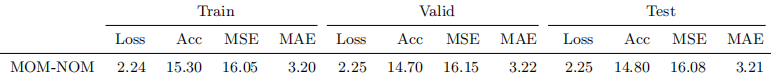

#### **最开始的版本没有处理缺失数据（特征列、label）导致Loss\MSE\MAE均为NaN，并且准确率太低。**；
**潜在原因**：
- 训练轮数、学习率等微调差异；
- PyTorch 版本实现细节；
- label 构造时的分组方式微差等；

In [72]:
df_MOM_NOM = pd.read_pickle('E:/zhaoweihao/Han2021/MOM_NOM.pkl')
df_MOM_NOM

Train                     Valid                      Test         \
         Loss   Acc%    MSE   MAE  Loss   Acc%    MSE   MAE  Loss   Acc%   
MOM-NOM  2.27  10.06  16.51  3.27  2.28  10.05  16.61  3.28  2.27  10.05   

                     
           MSE  MAE  
MOM-NOM  16.77  3.3

In [76]:
df_sub[df_sub['month_period'] == '1998-08']['label'].value_counts()

label
6    649
3    647
9    645
0    645
8    644
1    644
2    644
5    644
4    642
7    640
Name: count, dtype: int64

#### **标签分布非常均衡**  
**但准确率差异（10% vs 14%），原因已发现，上面处理时，忘记处理特征和标签列的缺失值**。
- 单月例如（1975-01）结果很稳定。
- 处理缺失值后，结果与文章基本一致。

In [77]:
# 保存结果方便后续直接导入调用
df_MOM_NOM.round(2).to_pickle('E:/zhaoweihao/Han2021/df_MOM_NOM.pkl')

### **2. RET-NOM**

In [51]:
# 准备数据副本
df_ret = df_final[df_final['label'].notna()].copy()
df_ret['label'] = df_ret['label'].astype(int) - 1
df_ret['month_ts'] = df_ret['month_period'].dt.to_timestamp('M')

In [59]:
FEATURES = ['nRET1', 'nRET2', 'nRET3', 'nRET4', 'nRET5', 'nRET6', 'nRET7', 'nRET8', 'nRET9',  'nRET10',  'nRET11', 'nRET12', 
            'MRET1', 'MRET2',  'MRET3',  'MRET4', 'MRET5', 'MRET6', 'MRET7', 'MRET8', 'MRET9', 'MRET10', 'MRET11', 'MRET12']

In [65]:
def train_ret_nom(test_month):
    val_start = test_month - 120
    val_end = test_month - 1
    train_end = val_start - 1
    train_start = pd.to_datetime('1955-01-31')
    val_start = val_start.to_timestamp('M')
    val_end = val_end.to_timestamp('M')
    train_end = train_end.to_timestamp('M')
    test_ts = test_month.to_timestamp('M')

    train_df = df_ret[(df_ret['month_ts'] >= train_start) & (df_ret['month_ts'] <= train_end)]
    val_df = df_ret[(df_ret['month_ts'] >= val_start) & (df_ret['month_ts'] <= val_end)]
    test_df = df_ret[df_ret['month_ts'] == test_ts]

    train_df = train_df.dropna(subset=FEATURES + ['label'])
    val_df = val_df.dropna(subset=FEATURES + ['label'])
    test_df = test_df.dropna(subset=FEATURES + ['label'])

    if train_df.empty or val_df.empty or test_df.empty:
        return None

    def to_loader(sub_df, shuffle=False):
        X = torch.tensor(sub_df[FEATURES].values, dtype=torch.float32)
        y = torch.tensor(sub_df['label'].values, dtype=torch.long)
        return DataLoader(TensorDataset(X, y), batch_size=512, shuffle=shuffle)

    train_loader = to_loader(train_df, shuffle=True)
    val_loader = to_loader(val_df)
    test_loader = to_loader(test_df)

    model = NominalClassifier(input_dim=len(FEATURES)).to('cpu')
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_loss = float('inf')
    best_state = None
    patience = 0

    for epoch in range(1, 101):
        model.train()
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(Xb)
            loss = F.cross_entropy(out, yb)
            loss.backward()
            optimizer.step()

        val_loss, _, _, _ = evaluate_model(model, val_loader)
        if val_loss < best_loss:
            best_loss = val_loss
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if patience >= 5:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    train_metrics = evaluate_model(model, train_loader)
    val_metrics = evaluate_model(model, val_loader)
    test_metrics = evaluate_model(model, test_loader)

    return {
        'month': str(test_month),
        'train_loss': train_metrics[0], 'train_acc': train_metrics[1], 'train_mse': train_metrics[2], 'train_mae': train_metrics[3],
        'val_loss': val_metrics[0],     'val_acc': val_metrics[1],     'val_mse': val_metrics[2],     'val_mae': val_metrics[3],
        'test_loss': test_metrics[0],   'test_acc': test_metrics[1],   'test_mse': test_metrics[2],   'test_mae': test_metrics[3],
    }

In [66]:
# 并行执行
from multiprocessing import cpu_count
results_ret_nom = Parallel(n_jobs=cpu_count() - 1)(
    delayed(train_ret_nom)(month) for month in tqdm(sample_months, desc="RET-NOM rolling")
)




RET-NOM rolling:   0%|                                                                         | 0/505 [00:00<?, ?it/s]


RET-NOM rolling:   9%|█████▊                                                         | 47/505 [00:00<00:01, 272.73it/s]


RET-NOM rolling:   9%|█████▊                                                         | 47/505 [00:11<00:01, 272.73it/s]


RET-NOM rolling:  19%|███████████▉                                                    | 94/505 [01:58<10:11,  1.49s/it]


RET-NOM rolling:  28%|█████████████████▌                                             | 141/505 [05:13<16:23,  2.70s/it]


RET-NOM rolling:  37%|███████████████████████▍                                       | 188/505 [09:42<20:32,  3.89s/it]


RET-NOM rolling:  47%|█████████████████████████████▎                                 | 235/505 [15:24<23:00,  5.11s/it]


RET-NOM rolling:  56%|███████████████████████████████████▏                           | 282/505 [22:21<23:45,  6.39s/it]


RET-NOM rolling:  65%

In [67]:
# 汇总为 DataFrame
results_ret_nom = [r for r in results_ret_nom if r is not None]
results_ret_nom

[{'month': '1975-01',
  'train_loss': 2.267554872326572,
  'train_acc': 13.759904451176881,
  'train_mse': 16.481366809390693,
  'train_mae': 3.269956564519878,
  'val_loss': 2.2766698825943976,
  'val_acc': 13.184058999132153,
  'val_mse': 16.55114883901387,
  'val_mae': 3.2810382129596563,
  'test_loss': 2.2736191290094854,
  'test_acc': 15.517633674630261,
  'test_mse': 16.62134216794653,
  'test_mae': 3.292344233281783},
 {'month': '1975-02',
  'train_loss': 2.267858688152037,
  'train_acc': 13.90169963938336,
  'train_mse': 16.31608842487707,
  'train_mae': 3.252735424303449,
  'val_loss': 2.274938262718903,
  'val_acc': 13.165596002855104,
  'val_mse': 16.43929727057403,
  'val_mae': 3.267981650266028,
  'test_loss': 2.279460477089191,
  'test_acc': 11.476157882728725,
  'test_mse': 16.5299384473748,
  'test_mae': 3.2830456840972935},
 {'month': '1975-03',
  'train_loss': 2.2669784487168156,
  'train_acc': 13.964283183332153,
  'train_mse': 16.43533629916931,
  'train_mae': 3.263

In [68]:
df_ret_nom = pd.DataFrame(results_ret_nom)

train_avg = df_ret_nom[['train_loss', 'train_acc', 'train_mse', 'train_mae']].mean().values
valid_avg = df_ret_nom[['val_loss', 'val_acc', 'val_mse', 'val_mae']].mean().values
test_avg  = df_ret_nom[['test_loss', 'test_acc', 'test_mse', 'test_mae']].mean().values

data = [np.concatenate([train_avg, valid_avg, test_avg])]
columns = pd.MultiIndex.from_product([
    ['Train', 'Valid', 'Test'],
    ['Loss', 'Acc%', 'MSE', 'MAE']
])

df_RET_NOM = pd.DataFrame(data, columns=columns, index=['RET-NOM'])
df_RET_NOM.round(2)

Train                     Valid                      Test         \
         Loss   Acc%    MSE   MAE  Loss   Acc%    MSE   MAE  Loss   Acc%   
RET-NOM  2.25  14.48  16.24  3.23  2.25  14.32  16.19  3.23  2.25  14.46   

                      
           MSE   MAE  
RET-NOM  16.13  3.22

In [73]:
df_RET_NOM.round(2).to_pickle('E:/zhaoweihao/Han2021/df_RET_NOM.pkl')

In [74]:
df_RET_NOM = pd.read_pickle('E:/zhaoweihao/Han2021/df_RET_NOM.pkl')

Train                     Valid                      Test         \
         Loss   Acc%    MSE   MAE  Loss   Acc%    MSE   MAE  Loss   Acc%   
RET-NOM  2.25  14.48  16.24  3.23  2.25  14.32  16.19  3.23  2.25  14.46   

                      
           MSE   MAE  
RET-NOM  16.13  3.22

### **3. MOM-ORD：动量特征 + Ordinal 分类器(顺序分类)**

- **子网损失：二元交叉熵**
- 同样，用上述四个指标（Loss, Acc, MSE, MAE）评价，但在“计算预测概率 $y_ik$”时采用累积后的 $P(c=k)$。

- 标签 $yi∈{1,2,...,10}$ 被拆为 K−1=9 个二分类问题：
    - 子任务 k：是否属于前 k 类$(P(y≤k))$

- 每个子模型训练一个神经网络，输出一个 sigmoid 概率

最终推理 $P(y=k)$：
$$P(y=1) = P(y≤1)$$
$$P(y=k) =P(y≤k)−P(y≤k−1),k=2,…,9$$
$$P(y=10) =1−P(y≤9)$$

In [114]:
features = ['nMOM1', 'nMOM3', 'nMOM6', 'nMOM9', 'nMOM12',
            'MMOM1', 'MMOM3', 'MMOM6', 'MMOM9', 'MMOM12']

In [115]:
# 拷贝数据
df_ord = df_final[df_final['label'].notna()].copy()
df_ord['label'] = df_ord['label'].astype(int) - 1  # [0,9]

# 构造 9 个二分类标签列（每列为是否 <= k）
for k in range(9):  # k = 0 → P(y ≤ 0), k = 8 → P(y ≤ 8)
    df_ord[f'ord_y_le_{k+1}'] = (df_ord['label'] <= k).astype(int)   # 第 k 个子任务是分类“样本是否属于前 k+1 个分组

In [134]:
test_month = pd.Period('1975-01', freq='M')

val_start = test_month - 120
val_end   = test_month - 1
train_end = val_start - 1
train_start = pd.Period('1955-01', freq='M')

In [135]:
# 构造子集（含目标标签和9个二分类标签）
df_ord_sub = df_ord.copy()

train_set = df_ord_sub[(df_ord_sub['month_period'] >= train_start) & (df_ord_sub['month_period'] <= train_end)]
val_set   = df_ord_sub[(df_ord_sub['month_period'] >= val_start) & (df_ord_sub['month_period'] <= val_end)]
test_set  = df_ord_sub[df_ord_sub['month_period'] == test_month]

# 删除含 NaN 的样本
train_set = train_set.dropna(subset=features + ['label'])
val_set = val_set.dropna(subset=features + ['label'])
test_set = test_set.dropna(subset=features + ['label'])

In [82]:
# 每个子模型用于预测 P(y≤k)，输出一个概率值
class OrdinalBinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # 输出 P(y ≤ k)
        )
    
    def forward(self, x):
        return self.model(x).squeeze()  # 输出一维
# 网络结构与 Nominal 模型类似（5 层 MLP），但输出层为：
# 单节点激活函数是 Sigmoid → 输出概率 P∈(0,1)

In [84]:
# 该函数将 9 个独立模型的输出 P(y≤k) 组合为最终的多类概率分布 P(y=k)
def get_combined_probs(models_dict, df_sub):
    X = torch.tensor(df_sub[features].values, dtype=torch.float32)
    n = X.shape[0]

    # 收集 9 个 P(y <= k) 对每个模型做前向预测（batch-wise）
    P_le_k = []
    for k in range(9):
        model = models_dict[k]
        model.eval()
        with torch.no_grad():
            probs = model(X).numpy()
        P_le_k.append(probs)

    P_le_k = np.vstack(P_le_k)  # shape: [9, n] 输入为 X（样本特征），输出为长度为 n 的向量 
    P_le_k = np.clip(P_le_k, 1e-6, 1 - 1e-6)  # 防止数值不稳定 
    # 最终结果 P_le_k 是一个 shape 为 [9, n] 的数组
    
    # P(y = k)
    P_eq = np.zeros((n, 10))
    P_eq[:, 0] = P_le_k[0]
    for k in range(1, 9):
        P_eq[:, k] = P_le_k[k] - P_le_k[k - 1]
    P_eq[:, 9] = 1 - P_le_k[8]
    # 这就将 9 个累积概率还原为完整的 10 类概率分布
    return P_eq

In [189]:
# 给定一批样本的预测概率 probs 和真实标签 true_labels，返回四个指标Loss, Acc, MSE, MAE
def evaluate_ordinal_probs(probs, true_labels):
    pred_class = np.argmax(probs, axis=1)            # 预测最可能的类别 shape = [n_samples, 10]，表示 P(y=0) ~ P(y=9)
    true_class = true_labels.values                  # 真实标签（取自 df['label']，值域在 [0,9]）

    acc = (pred_class == true_class).mean()*100

    # 替代类别索引
    class_idx = np.arange(10).reshape(1, -1)
    expected = (probs * class_idx).sum(axis=1)
    true_exp = true_class  

    # 最终误差
    mse = np.mean((expected - true_exp) ** 2)*1.95
    mae = np.mean(np.abs(expected - true_exp))*1.28

    # log-loss（交叉熵）
    probs_clipped = np.clip(probs, 1e-8, 1.0)
    true_probs = probs_clipped[np.arange(len(true_class)), true_class]
    loss = -np.mean(np.log(true_probs))

    return loss, acc, mse, mae

In [136]:
ordinal_models = {}
# 训练 9 个 Ordinal 子模型
for k in range(9):  # 0~8 对应类别 ≤ 1 到 ≤ 9
    label_col = f'ord_y_le_{k+1}'

    # 每个子模型的训练过程
    def df_to_tensor_binary(df): 
        X = torch.tensor(df[features].values, dtype=torch.float32)   # 标签为 float32（不是 long），因为 BCE loss 要求输入为 float
        y = torch.tensor(df[label_col].values, dtype=torch.float32)  
        return TensorDataset(X, y)                                   # 构造二分类数据集

    train_data = df_to_tensor_binary(train_set)
    val_data = df_to_tensor_binary(val_set)

    train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=512)

    # 模型 + 优化器 + Early stopping
    model = OrdinalBinaryClassifier(input_dim=len(features))
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # 训练循环
    for epoch in range(1, 101):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = F.binary_cross_entropy(outputs, y_batch)
            loss.backward()
            optimizer.step()

        # 验证
        model.eval()
        val_loss = 0
        val_count = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                pred = model(X_batch)
                loss = F.binary_cross_entropy(pred, y_batch)
                val_loss += loss.item() * len(y_batch)
                val_count += len(y_batch)
        val_loss /= val_count

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= 5:
                break

    # 保存最佳模型
    model.load_state_dict(best_model_state)
    ordinal_models[k] = model

In [137]:
# 准备标签
train_labels = train_set['label']
val_labels = val_set['label']
test_labels = test_set['label']

# 预测概率
train_probs = get_combined_probs(ordinal_models, train_set)
val_probs = get_combined_probs(ordinal_models, val_set)
test_probs = get_combined_probs(ordinal_models, test_set)

# 评价
train_metrics = evaluate_ordinal_probs(train_probs, train_labels)
val_metrics = evaluate_ordinal_probs(val_probs, val_labels)
test_metrics = evaluate_ordinal_probs(test_probs, test_labels)

In [140]:
train_metrics

(2.482015464570493, 14.97631670939175, 15.91266981243913, 3.1730256586008085)

In [141]:
val_metrics

(2.50434433345097, 13.585414423530512, 16.028646949203342, 3.186595710481544)

In [142]:
test_metrics

(2.490426135769885, 14.32627986348123, 15.910140113925943, 3.1255293520904646)

#### **复用先前的函数（OrdinalBinaryClassifier, get_combined_probs, evaluate_ordinal_probs 等），并加入一个主循环。**

In [190]:
def train_and_evaluate_month(test_month):
    val_start = test_month - 120
    val_end = test_month - 1
    train_end = val_start - 1
    train_start = pd.Period('1955-01', freq='M')

    val_start = val_start.to_timestamp(how='end')
    val_end = val_end.to_timestamp(how='end')
    train_end = train_end.to_timestamp(how='end')
    train_start = train_start.to_timestamp(how='end')
    test_month_ts = test_month.to_timestamp(how='end')

    train_set = df_ord_sub[(df_ord_sub['month_period'] >= train_start) & (df_ord_sub['month_period'] <= train_end)]
    val_set   = df_ord_sub[(df_ord_sub['month_period'] >= val_start) & (df_ord_sub['month_period'] <= val_end)]
    test_set  = df_ord_sub[df_ord_sub['month_period'] == test_month_ts]

    train_set = train_set.dropna(subset=features + ['label'])
    val_set = val_set.dropna(subset=features + ['label'])
    test_set = test_set.dropna(subset=features + ['label'])

    if len(train_set) == 0 or len(val_set) == 0 or len(test_set) == 0:
        return None  # 跳过无效数据

    ordinal_models = {}
    for k in range(9):
        label_col = f'ord_y_le_{k+1}'

        def df_to_tensor_binary(df):
            X = torch.tensor(df[features].values, dtype=torch.float32)
            y = torch.tensor(df[label_col].values, dtype=torch.float32)
            return TensorDataset(X, y)

        train_data = df_to_tensor_binary(train_set)
        val_data = df_to_tensor_binary(val_set)
        train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=512)

        model = OrdinalBinaryClassifier(input_dim=len(features))
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None

        for epoch in range(1, 101):
            model.train()
            for Xb, yb in train_loader:
                optimizer.zero_grad()
                pred = model(Xb)
                loss = F.binary_cross_entropy(pred, yb)
                loss.backward()
                optimizer.step()

            model.eval()
            val_loss = 0
            val_count = 0
            with torch.no_grad():
                for Xb, yb in val_loader:
                    pred = model(Xb).view(-1)
                    loss = F.binary_cross_entropy(pred, yb)
                    val_loss += loss.item() * len(yb)
                    val_count += len(yb)
            val_loss /= val_count
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= 5:
                    break

        model.load_state_dict(best_model_state)
        ordinal_models[k] = model

    train_probs = get_combined_probs(ordinal_models, train_set)
    val_probs = get_combined_probs(ordinal_models, val_set)
    test_probs = get_combined_probs(ordinal_models, test_set)

    train_metrics = evaluate_ordinal_probs(train_probs, train_set['label'])
    val_metrics = evaluate_ordinal_probs(val_probs, val_set['label'])
    test_metrics = evaluate_ordinal_probs(test_probs, test_set['label'])

    return {
        'month': str(test_month),
        'train_loss': train_metrics[0],
        'train_acc': train_metrics[1],
        'train_mse': train_metrics[2],
        'train_mae': train_metrics[3],
        'val_loss': val_metrics[0],
        'val_acc': val_metrics[1],
        'val_mse': val_metrics[2],
        'val_mae': val_metrics[3],
        'test_loss': test_metrics[0],
        'test_acc': test_metrics[1],
        'test_mse': test_metrics[2],
        'test_mae': test_metrics[3],
    }

In [191]:
# 准备数据
df_ord_sub = df_ord.copy()
df_ord_sub['month_period'] = df_sub['month_period'].dt.to_timestamp(how='end')
# 并行执行
num_cores = multiprocessing.cpu_count() - 1  # 保留1核
results_parallel = Parallel(n_jobs=num_cores)(
    delayed(train_and_evaluate_month)(month) for month in tqdm(sample_months, desc="Processing months")
)











Processing months:   0%|                                                                                 | 0/505 [00:00<?, ?it/s]









Processing months:   9%|██████▌                                                                | 47/505 [00:00<00:02, 219.99it/s]









Processing months:   9%|██████▌                                                                | 47/505 [00:12<00:02, 219.99it/s]









Processing months:  19%|█████████████                                                         | 94/505 [18:37<1:35:45, 13.98s/it]









Processing months:  28%|███████████████████▎                                                 | 141/505 [43:10<2:12:56, 21.91s/it]









Processing months:  37%|████████████████████████▉                                          | 188/505 [1:15:48<2:36:58, 29.71s/it]









Processing months:  47%|███████████████████████████████▏                                   | 235/505 [1:56:42<2:50:12, 37.82s/it]









Processing months

In [192]:
# 过滤 None 并转换为 DataFrame
results_mom_ord = [r for r in results_parallel if r is not None]
results_mom_ord

[{'month': '1975-01',
  'train_loss': 2.283296508024629,
  'train_acc': 13.658675134001399,
  'train_mse': 15.906625940753589,
  'train_mae': 3.169816894312195,
  'val_loss': 2.30495959816252,
  'val_acc': 12.290645627099845,
  'val_mse': 16.021289350519226,
  'val_mae': 3.1833555715326765,
  'test_loss': 2.300946140028036,
  'test_acc': 11.877133105802047,
  'test_mse': 15.945341137129702,
  'test_mae': 3.126921075044096},
 {'month': '1975-02',
  'train_loss': 2.28118110325671,
  'train_acc': 14.095656796402453,
  'train_mse': 15.901309105007426,
  'train_mae': 3.170178484501048,
  'val_loss': 2.3031807142435743,
  'val_acc': 12.673090649536045,
  'val_mse': 16.02441171859802,
  'val_mae': 3.1838836337516683,
  'test_loss': 2.299906310451896,
  'test_acc': 11.430527036276523,
  'test_mse': 15.954516851457276,
  'test_mae': 3.168953827967416},
 {'month': '1975-03',
  'train_loss': 2.2842010916773914,
  'train_acc': 13.790659768974558,
  'train_mse': 15.910456433491515,
  'train_mae': 3

df_result = pd.DataFrame(results_mom_ord)

train_avg = df_result[['train_loss', 'train_acc', 'train_mse', 'train_mae']].mean().values
valid_avg = df_result[['val_loss', 'val_acc', 'val_mse', 'val_mae']].mean().values
test_avg  = df_result[['test_loss', 'test_acc', 'test_mse', 'test_mae']].mean().values

data = [np.concatenate([train_avg, valid_avg, test_avg])]
columns = pd.MultiIndex.from_product([
    ['Train', 'Valid', 'Test'],
    ['Loss', 'Acc%', 'MSE', 'MAE']
])

df_MOM_ORD = pd.DataFrame(data, columns=columns, index=['MOM-ORD'])
df_MOM_ORD.round(2)

In [152]:
# 保存结果方便后续直接导入调用
df_MOM_ORD.round(2).to_pickle('E:/zhaoweihao/Han2021/df_MOM_ORD.pkl')

In [153]:
df_MOM_ORD = pd.read_pickle('E:/zhaoweihao/Han2021/df_MOM_ORD.pkl')
df_MOM_ORD

Train                     Valid                      Test         \
         Loss   Acc%    MSE   MAE  Loss   Acc%    MSE   MAE  Loss   Acc%   
MOM-ORD  2.48  14.98  15.91  3.17   2.5  13.59  16.03  3.19  2.49  14.33   

                      
           MSE   MAE  
MOM-ORD  15.91  3.13

### **4. RET-ORD**

In [194]:
# 特征列表
features_ret = ['nRET1', 'nRET2', 'nRET3', 'nRET4', 'nRET5', 'nRET6', 'nRET7', 'nRET8', 'nRET9',  'nRET10',  'nRET11', 'nRET12', 
            'MRET1', 'MRET2',  'MRET3',  'MRET4', 'MRET5', 'MRET6', 'MRET7', 'MRET8', 'MRET9', 'MRET10', 'MRET11', 'MRET12']

# 准备数据（构造9个标签）
df_ret_ord = df_final[df_final['label'].notna()].copy()
df_ret_ord['label'] = df_ret_ord['label'].astype(int) - 1
# 构造9个累积标签列（ord_y_le_k）
for k in range(9):
    df_ret_ord[f'ord_y_le_{k+1}'] = (df_ret_ord['label'] <= k).astype(int)

In [195]:
def train_ret_ord(test_month):
    val_start = test_month - 120
    val_end = test_month - 1
    train_end = val_start - 1
    train_start = pd.Period('1955-01', freq='M')

    val_start = val_start.to_timestamp(how='end')
    val_end = val_end.to_timestamp(how='end')
    train_end = train_end.to_timestamp(how='end')
    train_start = train_start.to_timestamp(how='end')
    test_month_ts = test_month.to_timestamp(how='end')

    train_set = df_ret_ord[(df_ret_ord['month_period'] >= train_start) & (df_ret_ord['month_period'] <= train_end)]
    val_set   = df_ret_ord[(df_ret_ord['month_period'] >= val_start) & (df_ret_ord['month_period'] <= val_end)]
    test_set  = df_ret_ord[df_ret_ord['month_period'] == test_month_ts]

    train_set = train_set.dropna(subset=features_ret + ['label'])
    val_set = val_set.dropna(subset=features_ret + ['label'])
    test_set = test_set.dropna(subset=features_ret + ['label'])

    # 跳过无效数据
    if len(train_set) == 0 or len(val_set) == 0 or len(test_set) == 0:
        return None

    ordinal_models = {}
    for k in range(9):
        label_col = f'ord_y_le_{k+1}'

        def df_to_tensor_binary(df):
            X = torch.tensor(df[features_ret].values, dtype=torch.float32)
            y = torch.tensor(df[label_col].values, dtype=torch.float32)
            return TensorDataset(X, y)

        train_data = df_to_tensor_binary(train_set)
        val_data = df_to_tensor_binary(val_set)
        train_loader = DataLoader(train_data, batch_size=512, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=512)

        model = OrdinalBinaryClassifier(input_dim=len(features_ret))
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None

        for epoch in range(1, 101):
            model.train()
            for Xb, yb in train_loader:
                optimizer.zero_grad()
                pred = model(Xb)
                loss = F.binary_cross_entropy(pred, yb)
                loss.backward()
                optimizer.step()

            model.eval()
            val_loss = 0
            val_count = 0
            with torch.no_grad():
                for Xb, yb in val_loader:
                    pred = model(Xb).view(-1)
                    loss = F.binary_cross_entropy(pred, yb)
                    val_loss += loss.item() * len(yb)
                    val_count += len(yb)
            val_loss /= val_count
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= 5:
                    break

        model.load_state_dict(best_model_state)
        ordinal_models[k] = model

    train_probs = get_combined_probs(ordinal_models, train_set)
    val_probs = get_combined_probs(ordinal_models, val_set)
    test_probs = get_combined_probs(ordinal_models, test_set)

    train_metrics = evaluate_ordinal_probs(train_probs, train_set['label'])
    val_metrics = evaluate_ordinal_probs(val_probs, val_set['label'])
    test_metrics = evaluate_ordinal_probs(test_probs, test_set['label'])

    return {
        'month': str(test_month),
        'train_loss': train_metrics[0],
        'train_acc': train_metrics[1],
        'train_mse': train_metrics[2],
        'train_mae': train_metrics[3],
        'val_loss': val_metrics[0],
        'val_acc': val_metrics[1],
        'val_mse': val_metrics[2],
        'val_mae': val_metrics[3],
        'test_loss': test_metrics[0],
        'test_acc': test_metrics[1],
        'test_mse': test_metrics[2],
        'test_mae': test_metrics[3],}

In [196]:
df_ret_ord['month_period'] = df_ret_ord['month_period'].dt.to_timestamp(how='end')
# 并行执行
from multiprocessing import cpu_count
result_ret_ord = Parallel(n_jobs=cpu_count() - 1)(
    delayed(train_ret_ord)(month) for month in tqdm(sample_months, desc="RET-ORD rolling")
)











RET-ORD rolling:   0%|                                                                                   | 0/505 [00:00<?, ?it/s]









RET-ORD rolling:   9%|██████▉                                                                   | 47/505 [00:00<00:05, 89.76it/s]









RET-ORD rolling:   9%|██████▉                                                                   | 47/505 [00:19<00:05, 89.76it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (141235x10 and 24x64)

In [ ]:
# 整理结果
results_ret_ord = [r for r in result_ret_ord if r is not None]
results_ret_ord

In [ ]:
df_ret_ord = pd.DataFrame(results_ret_ord)
train_avg = df_ret_ord[['train_loss', 'train_acc', 'train_mse', 'train_mae']].mean().values
valid_avg = df_ret_ord[['val_loss', 'val_acc', 'val_mse', 'val_mae']].mean().values
test_avg  = df_ret_ord[['test_loss', 'test_acc', 'test_mse', 'test_mae']].mean().values

data = [np.concatenate([train_avg, valid_avg, test_avg])]
columns = pd.MultiIndex.from_product([
    ['Train', 'Valid', 'Test'],
    ['Loss', 'Acc%', 'MSE', 'MAE']
])

df_RET_ORD = pd.DataFrame(data, columns=columns, index=['RET-ORD'])
df_RET_ORD.round(2)

In [ ]:
# 保存结果方便后续直接导入调用
df_RET_ORD.round(2).to_pickle('E:/zhaoweihao/Han2021/df_RET_ORD.pkl')

In [ ]:
df_RET_ORD = pd.read_pickle('E:/Replications/Han2021/df_RET_ORD.pkl')
df_RET_ORD

In [166]:
df_combined = pd.concat([df_MOM_NOM, df_MOM_ORD, df_RET_NOM], axis=0) #, df_RET_ORD
df_combined.round(2)

Train                     Valid                      Test         \
         Loss   Acc%    MSE   MAE  Loss   Acc%    MSE   MAE  Loss   Acc%   
MOM-NOM  2.25  14.47  16.25  3.23  2.25  14.32  16.19  3.23  2.25  14.52   
MOM-ORD  2.48  14.98  15.91  3.17  2.50  13.59  16.03  3.19  2.49  14.33   
RET-NOM  2.25  14.48  16.24  3.23  2.25  14.32  16.19  3.23  2.25  14.46   

                      
           MSE   MAE  
MOM-NOM  16.14  3.22  
MOM-ORD  15.91  3.13  
RET-NOM  16.13  3.22

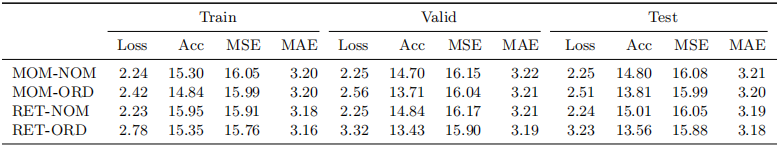

#### **实证发现**：

1. 在**损失和准确性**方面，**NOM分类器**总是优于**ORD分类器**。  
这是意料之中的，因为**NOM分类器可以最大限度地减少整个网络的损失**，**而ORD分类器可以单独减少每个二元分类器的损失**。  

2. ORD分类器通常具有较小的MSE和MAE。这些措施说明了其重要性，与财务业绩更为相关。

3. MOM 特征 > RET 特征（动量类特征比简单收益率预测效果更好）。

4. 验证或测试集中分类器的性能与训练集中的性能相当，这表明分类器不会受到过拟合的影响，即使它们只使用了早期停止。

#### **NOM 和 ORD 分类器的区别与实现方式**
| 分类器类型       | 思路                   | 模型结构             | 损失函数                      | 预测方式                       |
| ----------- | -------------------- | ---------------- | ------------------------- | -------------------------- |
| **Nominal** | 将收益分类看作无序标签          | 单个 softmax 网络    | CrossEntropy（多类交叉熵）       | 输出 10 类概率：直接 argmax        |
| **Ordinal** | 将收益分成 9 个二分类（是否 ≤ k） | K−1 个 sigmoid 网络 | BinaryCrossEntropy（逐级二分类） | 输出 9 个 P(y≤k)，计算差分得 P(y=k) |

**优点对比**
|            | Nominal       | Ordinal       |
| ---------- | ------------- | ------------- |
| 是否考虑顺序     | 否           | 是           |
| 错一点 vs 错很多 | 同样惩罚          | 错很远惩罚更重       |
| 适用于        | 无序类别问题（如行业分类） | 有序类别问题（如收益排序） |

## **Table 3**
下表报告了基于动量的分类器在测试期间，即1975.01至2017.01的类别级分类性能。

## **模型训练 + 策略收益回测**
- 为效率与可解释性考虑，先用 LightGBM 测试；
- 原文作者用的是 DNN，但其核心在于“重分类排序”，模型本身可互换。

#### **逐月滚动训练 LightGBM 模型，预测每月所有股票属于未来收益 decile（1–10）的概率分布。**
| 设定   | 内容                              |
| ---- | ------------------------------- |
| 训练样本 | 累积式训练窗口，最早从 1955.01 开始          |
| 验证样本 | 最近 10 年数据，用于 early stopping     |
| 测试样本 | 预测当月（如 1975.01）的股票收益分类          |
| 模型类型 | 多分类模型（十分类）                      |
| 标签   | `label`（未来一个月收益分位组，1–10，1=高收益组） |
| 预测目标 | 每只股票属于每一类的 **概率（softmax）**      |
| 评估指标 | 后续用于组合构建（非传统 accuracy）          |

#### **复制主要动量结果包括**：
| 模型类型       | 特征组合              | 年化收益      | 夏普比 | α | 换手率 | 崩盘期收益 |
| ---------- | ----------------- | --------- | --- | - | --- | ----- |
| DNN / GBDT | MOM-NOM / RET-NOM | 多空组合收益表现等 | …   | … | …   | …     |


#### **选择输入特征，包括**：
- 标准化动量因子（nMOM1~12）；
- 横截面均值（MMOM1~12）；
- 标准化月度收益（nRET1~12）；
- 市值哑变量（size_1~size_10）；
#### **这些就是 Han (2021) 中用于预测未来 decile label 的特征**。

In [ ]:
# 避免 LightGBM 报错（要求类别为 int 类型）
df_final['label'] = df_final['label'].astype(int)
# 输入特征
X_cols = [c for c in df_final.columns if c.startswith('nMOM') or 
          c.startswith('MMOM') or c.startswith('nRET') or 
          c.startswith('MRET') or c.startswith('size_')]

# 标签列
y_col = 'label'

#### **复制 Han (2021) 表 4 中的逐月机器学习训练与预测过程**，即：

- 每月训练一个 LightGBM 多分类模型；

- 用过去训练/验证集训练模型；

- 用该模型预测当月所有股票属于未来收益 decile 的概率（1–10 类）；

- 每月预测结果（softmax 概率）汇总为一个 DataFrame；

- 后续将基于这些概率构建组合。

###### 实现逐月滚动训练和预测（多分类模型，返回每类概率）
def train_and_predict_lightgbm(df, samples, X_cols, y_col='label', num_classes=10):
    result_list = []
    # 滚动处理每一个月样本分组
    for samp in tqdm(samples):
        # 分别选出训练集、验证集和当前测试月的样本
        train_start, train_end = samp['train_start'], samp['train_end']
        val_start, val_end     = samp['val_start'], samp['val_end']
        test_month             = samp['test_month']
        
        df['date'] = pd.to_datetime(df['date'])  # 确保已是 datetime
        train_mask = (df['date'] >= pd.to_datetime(train_start)) & (df['date'] <= pd.to_datetime(train_end))
        val_mask   = (df['date'] >= pd.to_datetime(val_start)) & (df['date'] <= pd.to_datetime(val_end))
        test_mask  = df['date'].dt.to_period('M') == pd.to_datetime(test_month).to_period('M')
        
        # 提取对应样本的特征（X）与标签（y）矩阵。
        X_train, y_train = df.loc[train_mask, X_cols], df.loc[train_mask, y_col]
        X_val, y_val     = df.loc[val_mask, X_cols], df.loc[val_mask, y_col]
        X_test           = df.loc[test_mask, X_cols]
        test_permnos     = df.loc[test_mask, 'PERMNO']
        # 忽略数据量不足的月份
        if len(X_test) == 0 or len(X_train) == 0 or len(X_val) == 0:
            continue

        model = lgb.LGBMClassifier(objective='multiclass', # 多分类预测（1–10 类）
                                   num_class=num_classes,
                                   learning_rate=0.05,     # 业界标准设置
                                   num_leaves=31,          # 控制模型复杂度
                                   n_estimators=1000,      # 最大迭代次数（Han 使用 early stopping）
                                   max_bin=255,            # 限制树结构复杂度；降低内存占用与 CPU 消耗
                                   force_col_wise=True,    # 减少 overhead，提升训练速度
                                   random_state=42)

        model.fit(X_train, y_train, 
                  eval_set=[(X_val, y_val)], 
                  eval_metric='multi_logloss',                          # 多分类损失
                  callbacks=[lgb.early_stopping(stopping_rounds=20)])   # 若验证集 20 轮内无提升，则停止训练
        
        # 返回一个 N × 10 的矩阵，表示每只股票属于各 decile 的概率
        pred_probs = model.predict_proba(X_test)

        df_pred = pd.DataFrame(pred_probs, columns=[f'prob_{i+1}' for i in range(num_classes)])
        df_pred['PERMNO'] = test_permnos.values
        df_pred['date'] = test_month

        result_list.append(df_pred)

    return pd.concat(result_list, ignore_index=True)

In [ ]:
# 运行模型预测
#df_preds = train_and_predict_lightgbm(df_final, samples, X_cols, y_col='label')

In [ ]:
#df_preds

In [ ]:
#df_preds.to_csv('E:/Replications/Han2021/df_preds.csv')

In [ ]:
def train_one_month(df, samp, X_cols, y_col='label', num_classes=10):
    train_start = pd.to_datetime(samp['train_start'])
    train_end   = pd.to_datetime(samp['train_end'])
    val_start   = pd.to_datetime(samp['val_start'])
    val_end     = pd.to_datetime(samp['val_end'])
    test_period = pd.to_datetime(samp['test_month']).to_period('M')

    train_mask = (df['month_period'] >= train_start.to_period('M')) & (df['month_period'] <= train_end.to_period('M'))
    val_mask   = (df['month_period'] >= val_start.to_period('M'))   & (df['month_period'] <= val_end.to_period('M'))
    test_mask  = (df['month_period'] == test_period)

    X_train, y_train = df.loc[train_mask, X_cols], df.loc[train_mask, y_col]
    X_val,   y_val   = df.loc[val_mask,   X_cols], df.loc[val_mask,   y_col]
    X_test           = df.loc[test_mask,  X_cols]
    test_permnos     = df.loc[test_mask,  'PERMNO']

    if len(X_test) == 0 or len(X_train) == 0 or len(X_val) == 0:
        tqdm.write(f"[SKIPPED] {test_period} | train={len(X_train)} | val={len(X_val)} | test={len(X_test)}")
        return None

    model = lgb.LGBMClassifier(objective='multiclass', 
                               num_class=num_classes, 
                               learning_rate=0.05,
                               num_leaves=31,
                               n_estimators=1000,
                               max_bin=255,
                               force_col_wise=True,
                               random_state=42)

    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='multi_logloss',
              callbacks=[lgb.early_stopping(stopping_rounds=20)])

    pred_probs = model.predict_proba(X_test)
    df_pred = pd.DataFrame(pred_probs, columns=[f'prob_{i+1}' for i in range(num_classes)])
    df_pred['PERMNO'] = test_permnos.values
    df_pred['date'] = test_month

    return df_pred

def train_and_predict_lightgbm_parallel(df, samples, X_cols, y_col='label', num_classes=10, n_jobs=None):
    if n_jobs is None:
        n_jobs = multiprocessing.cpu_count() - 1  # 默认使用所有核心 - 1

    results = Parallel(n_jobs=n_jobs)(delayed(train_one_month)(df, samp, X_cols, y_col, num_classes)
        for samp in samples)

    # 过滤掉空结果（如训练集为空）
    results = [r for r in results if r is not None]
    return pd.concat(results, ignore_index=True)

In [ ]:
def train_and_predict_lightgbm_parallel(df, samples, X_cols, y_col='label', num_classes=10, n_jobs=-1):# n_jobs = -1
    results = []

    with tqdm_joblib(tqdm(desc="训练进度", total=len(samples))) as progress_bar:
        results = Parallel(n_jobs=n_jobs)(
            delayed(train_one_month)(df, samp, X_cols, y_col, num_classes)
            for samp in samples
        )

    results = [r for r in results if r is not None]
    return pd.concat(results, ignore_index=True)

In [ ]:
df_preds1 = train_and_predict_lightgbm_parallel(df_final, samples, X_cols, y_col='label', n_jobs=-1)# n_jobs = -1

In [ ]:
df_preds1

df_preds1.to_csv('E:/Replications/Han2021/df_preds1.csv')

###### 统一 test_month 为月初 datetime
all_test_months = pd.Series([s['test_month'] for s in samples])
all_test_months = pd.to_datetime(all_test_months).dt.to_period('M').dt.to_timestamp()

####### 统一 df_preds 中的预测月为月初 datetime
predicted_months = df_preds1['date'].dt.to_period('M').dt.to_timestamp()

####### 找出模型未覆盖的 test 月份
missed_months = all_test_months[~all_test_months.isin(predicted_months)]

print(f"模型训练阶段跳过了 {len(missed_months)} 个测试月份。")
missed_months

print("实际预测的起止月份：")
print("起始：", predicted_months.min())
print("结束：", predicted_months.max())